<a href="https://colab.research.google.com/github/felixzhao/stat501-project/blob/main/notebooks/V7_3_FZ_PCA_for_cluster_top_10_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This version based on un-normalize data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/pre_process_round_1"

Mounted at /content/drive
 01_selected_data.csv			 05_preprocessed_full_raw_data.gsheet
 02_almost_complete_data.csv		 citi_agg_start_end_reg.csv
 02_almost_complete_data.gsheet		 citi_agg_texts.csv
 03_full_data.csv			 citi_agg_texts.gsheet
 03_full_data.gsheet			 Clustering
'04_preprocessed_full_data (1).gsheet'	'Clustering pdf.gdoc'
'04_preprocessed_full_data (2).gsheet'	'start_end_registrations (1).gsheet'
 04_preprocessed_full_data.csv		 start_end_registrations.csv
 04_preprocessed_full_data.gsheet	 start_end_registrations.gsheet
 05_preprocessed_full_raw_data.csv	 start_end_registrations_wide.csv


# path

In [3]:
output_dir = "/content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/clusters"
cluster_paths = []
for i in range(1, 6):
    path = os.path.join(output_dir,f'cluster_{i}.csv')
    print(path)
    cluster_paths.append(path)

/content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/clusters/cluster_1.csv
/content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/clusters/cluster_2.csv
/content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/clusters/cluster_3.csv
/content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/clusters/cluster_4.csv
/content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/clusters/cluster_5.csv


# functions

In [4]:
def step_0_load(path):
    df = pd.read_csv(path, low_memory=False, index_col=False)
    # Separating out the features
    features = df.columns

    # Standardizing the features
    x = StandardScaler().fit_transform(df[features])
    return x, features

In [5]:
def get_best_number_of_components(x):
    # df = pd.read_csv(raw_path, low_memory=False, index_col=False)
    # # Separating out the features
    # features = df.columns

    # # Standardizing the features
    # x = StandardScaler().fit_transform(df[features])

    # Choosing the number of components
    n_comp = 50 if min(x.shape) > 50 else min(x.shape)

    pca = PCA(n_components=n_comp)  # Here, we're reducing the data to 2 dimensions

    principal_components = pca.fit_transform(x)

    # Convert to DataFrame for easier handling
    principal_df = pd.DataFrame(data=principal_components) #, columns=['Principal Component 1', 'Principal Component 2'])

    explained_variance = pca.explained_variance_ratio_
    print(f"Explained Variance by Component: {explained_variance}")

    # Assuming X is your standardized data
    pca = PCA().fit(x)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because Python uses 0-based indexing

    # Plotting the explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.axvline(x=num_components, color='r', linestyle='--')
    plt.axhline(y=0.95, color='g', linestyle='--')
    plt.grid(True)

    # Annotate the number of components
    plt.annotate(f'{num_components} components', xy=(num_components, 0.5), xytext=(num_components+5, 0.6),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=9)

    plt.show()

    return num_components


In [6]:
def step_3_cluster_analysis(x, features, num_of_components):
    # Assuming X is your standardized data
    pca_22 = PCA(n_components=num_of_components)
    principal_components_22 = pca_22.fit_transform(x)

    # Convert to DataFrame for easier handling (optional)
    df_pca_22 = pd.DataFrame(data=principal_components_22, columns=[f'PC{i+1}' for i in range(num_of_components)])

    components_22 = pd.DataFrame(pca_22.components_, columns=features, index=[f'PC{i+1}' for i in range(num_of_components)])

    # Extract the explained variance of each component
    explained_variance_22 = pca_22.explained_variance_ratio_

    # Convert to DataFrame for easier visualization
    df_variance_22 = pd.DataFrame({'Component': [f'PC{i+1}' for i in range(num_of_components)],
                                'Explained Variance': explained_variance_22})

    print(df_variance_22)

    plt.figure(figsize=(15, 7))
    plt.bar(df_variance_22['Component'], df_variance_22['Explained Variance'])
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance of Each Principal Component')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Assuming pca is a PCA object you've already fitted on your data
    explained_variance = pca_22.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.title('Explained Variance by Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Plot the heatmap
    plt.figure(figsize=(35, 20))
    sns.heatmap(components_22, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Heatmap Visualization')
    plt.show()

    # Number of top features you want to identify for each component
    num_top_features = 5

    # For each component, find the top features based on the absolute loadings
    top_features_per_component = {}
    for i, component in components_22.iterrows():
        print(f"{i=}")
        top_features = component.abs().nlargest(num_top_features).index.tolist()
        top_features_per_component[i] = top_features

    # Display the top features for each component
    for component, top_features in top_features_per_component.items():
        print(f"{component}: {', '.join(top_features)}")

    # Sum the absolute loadings for each feature across all components
    aggregate_loadings = components_22.abs().sum(axis=0)

    # Sort the features based on the aggregate loadings
    sorted_features = aggregate_loadings.sort_values(ascending=False)

    # Display the sorted features
    print("TOP 10 features")
    print(sorted_features[:10])
    return sorted_features

# Process all cluster


Cluster 1: /content/drive/My Drive/Study@NZ/VUW@NZ/STATS 501/Project/clusters/cluster_1.csv
Explained Variance by Component: [1.68671129e-01 1.10034508e-01 8.83227766e-02 7.06513813e-02
 5.96605009e-02 5.32703233e-02 4.62349930e-02 4.53496584e-02
 4.13393490e-02 3.51580340e-02 3.12371092e-02 3.01599790e-02
 2.85421504e-02 2.73476317e-02 2.05048640e-02 2.01355481e-02
 1.87133601e-02 1.61670826e-02 1.34024562e-02 1.22021226e-02
 1.13311196e-02 9.81579038e-03 9.21219734e-03 6.82249180e-03
 5.94474024e-03 4.30040423e-03 3.76178221e-03 3.08396261e-03
 2.35511024e-03 1.54072170e-03 1.41232711e-03 1.05446200e-03
 8.95448524e-04 4.60282615e-04 3.03869618e-04 2.44228784e-04
 1.45433838e-04 1.14605272e-04 8.60908295e-05 9.97374273e-06
 7.62331687e-34]


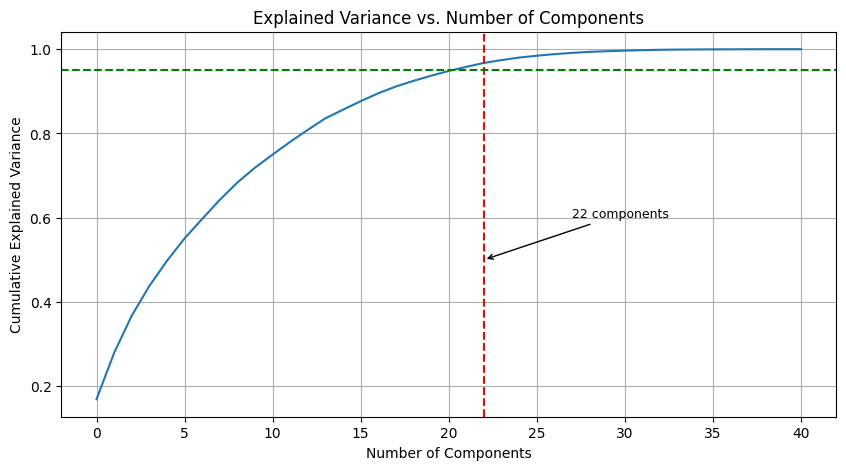

   Component  Explained Variance
0        PC1            0.168671
1        PC2            0.110035
2        PC3            0.088323
3        PC4            0.070651
4        PC5            0.059661
5        PC6            0.053270
6        PC7            0.046235
7        PC8            0.045350
8        PC9            0.041339
9       PC10            0.035158
10      PC11            0.031237
11      PC12            0.030160
12      PC13            0.028542
13      PC14            0.027348
14      PC15            0.020505
15      PC16            0.020136
16      PC17            0.018713
17      PC18            0.016167
18      PC19            0.013402
19      PC20            0.012202
20      PC21            0.011331
21      PC22            0.009816


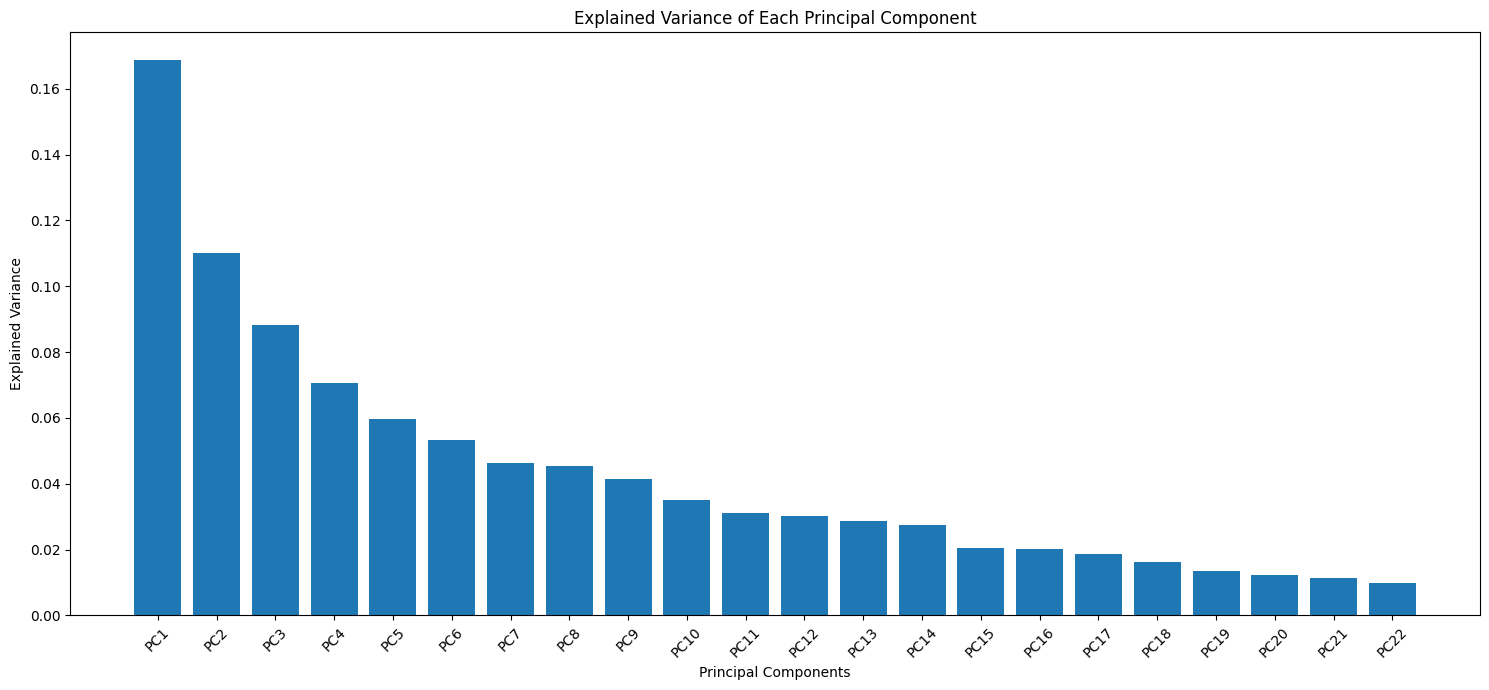

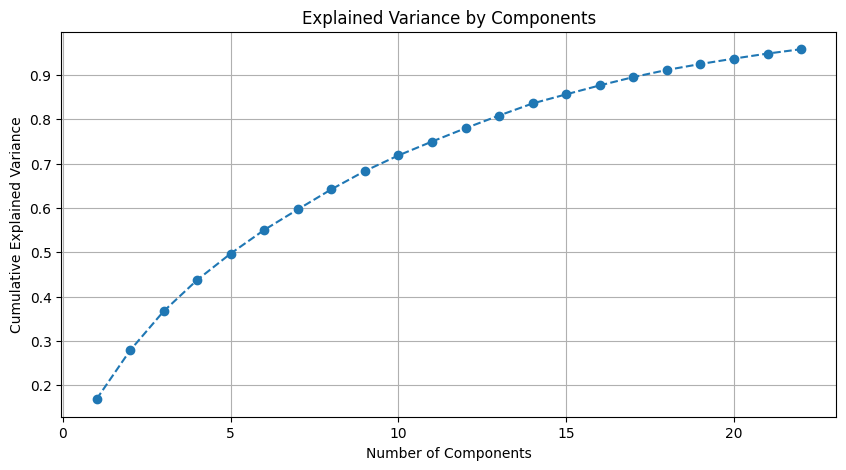

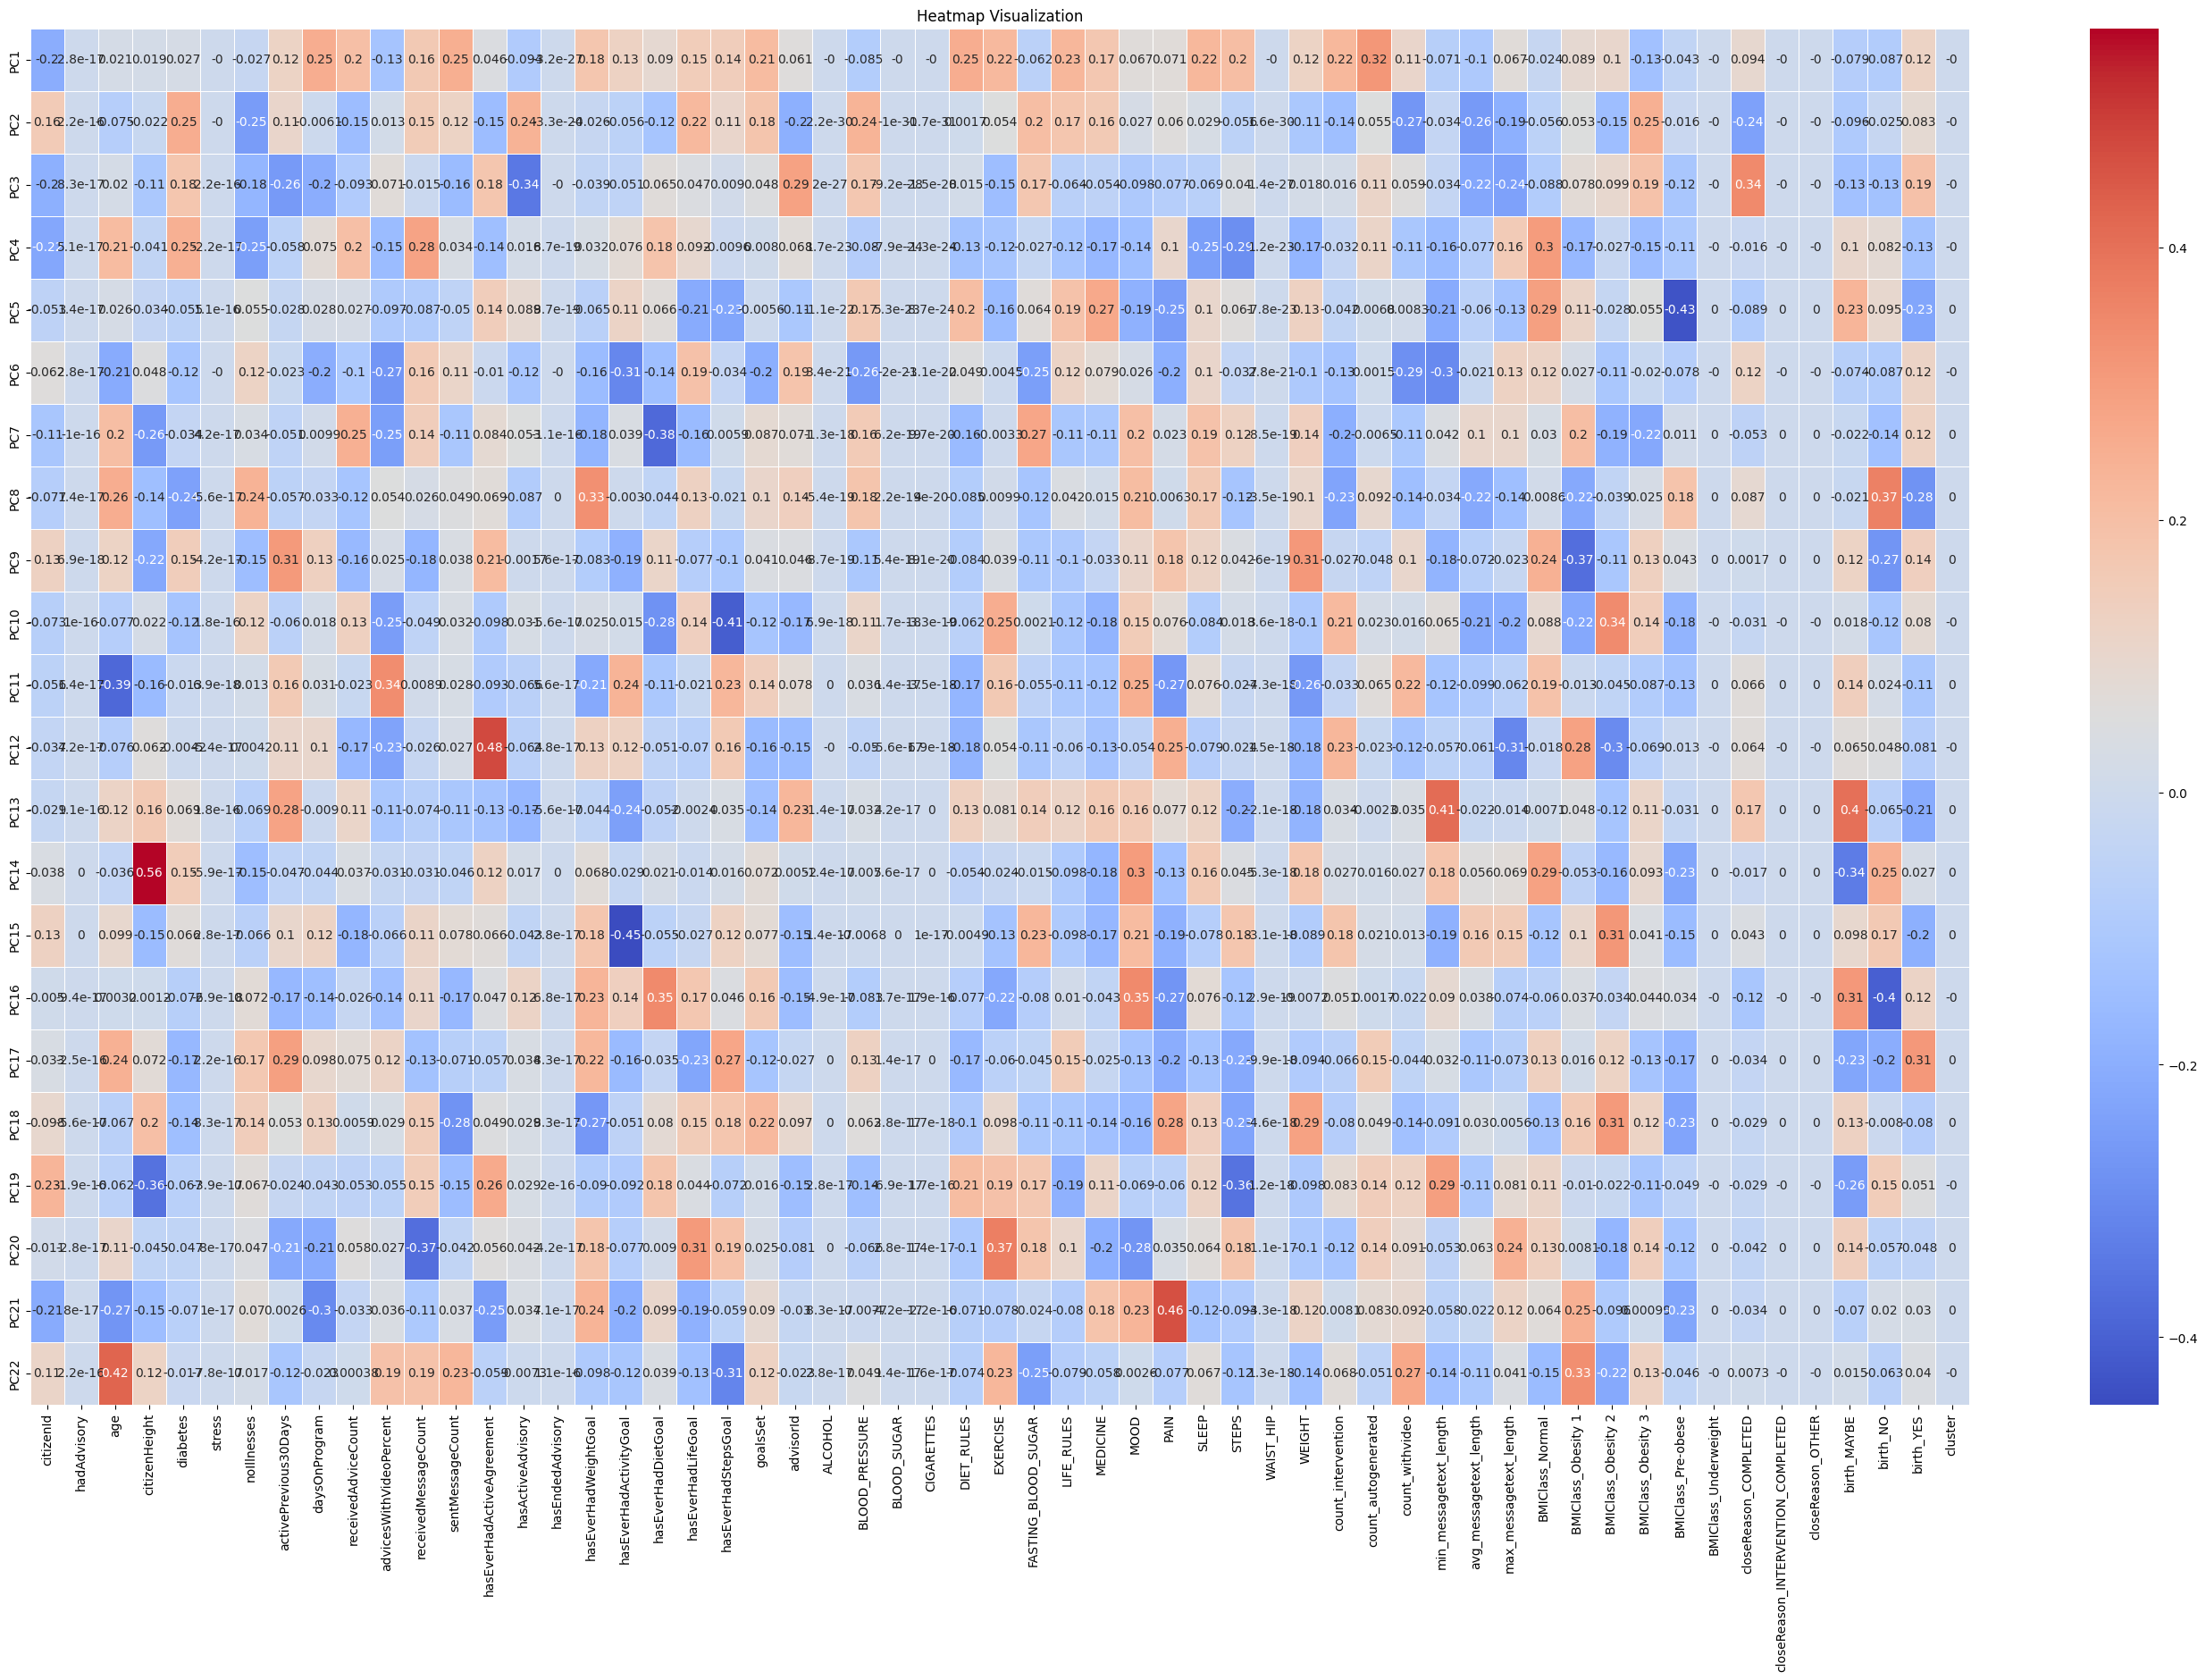

i='PC1'
i='PC2'
i='PC3'
i='PC4'
i='PC5'
i='PC6'
i='PC7'
i='PC8'
i='PC9'
i='PC10'
i='PC11'
i='PC12'
i='PC13'
i='PC14'
i='PC15'
i='PC16'
i='PC17'
i='PC18'
i='PC19'
i='PC20'
i='PC21'
i='PC22'
PC1: count_autogenerated, DIET_RULES, daysOnProgram, sentMessageCount, LIFE_RULES
PC2: count_withvideo, avg_messagetext_length, diabetes, noIllnesses, BMIClass_Obesity 3
PC3: hasActiveAdvisory, closeReason_COMPLETED, advisorId, activePrevious30Days, max_messagetext_length
PC4: BMIClass_Normal, STEPS, receivedMessageCount, SLEEP, diabetes
PC5: BMIClass_Pre-obese, BMIClass_Normal, MEDICINE, PAIN, birth_MAYBE
PC6: hasEverHadActivityGoal, min_messagetext_length, count_withvideo, advicesWithVideoPercent, BLOOD_PRESSURE
PC7: hasEverHadDietGoal, FASTING_BLOOD_SUGAR, citizenHeight, advicesWithVideoPercent, receivedAdviceCount
PC8: birth_NO, hasEverHadWeightGoal, birth_YES, age, diabetes
PC9: BMIClass_Obesity 1, WEIGHT, activePrevious30Days, birth_NO, BMIClass_Normal
PC10: hasEverHadStepsGoal, BMIClass_Obesit

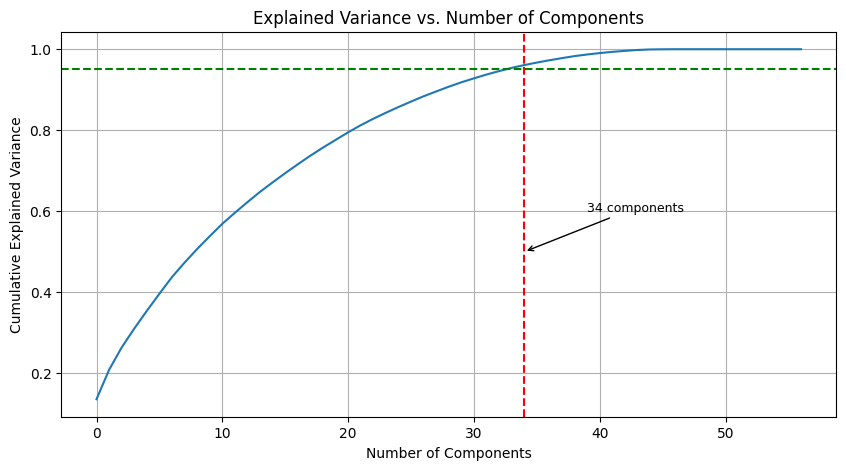

   Component  Explained Variance
0        PC1            0.136053
1        PC2            0.072512
2        PC3            0.055242
3        PC4            0.046591
4        PC5            0.043838
5        PC6            0.042186
6        PC7            0.041183
7        PC8            0.035709
8        PC9            0.033575
9       PC10            0.031573
10      PC11            0.030614
11      PC12            0.027277
12      PC13            0.026223
13      PC14            0.025408
14      PC15            0.023403
15      PC16            0.022674
16      PC17            0.021911
17      PC18            0.021271
18      PC19            0.019886
19      PC20            0.019004
20      PC21            0.018757
21      PC22            0.017493
22      PC23            0.016014
23      PC24            0.014759
24      PC25            0.014184
25      PC26            0.013408
26      PC27            0.013102
27      PC28            0.011915
28      PC29            0.011725
29      PC

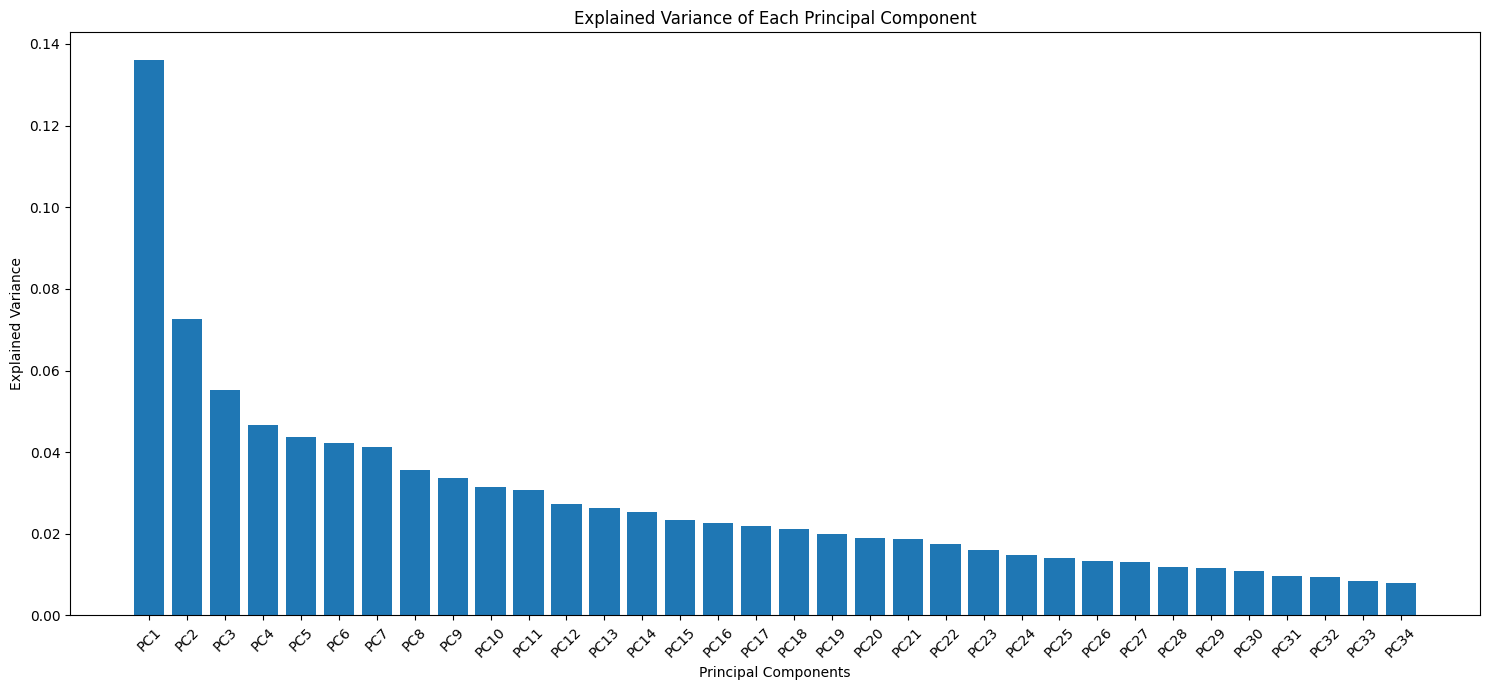

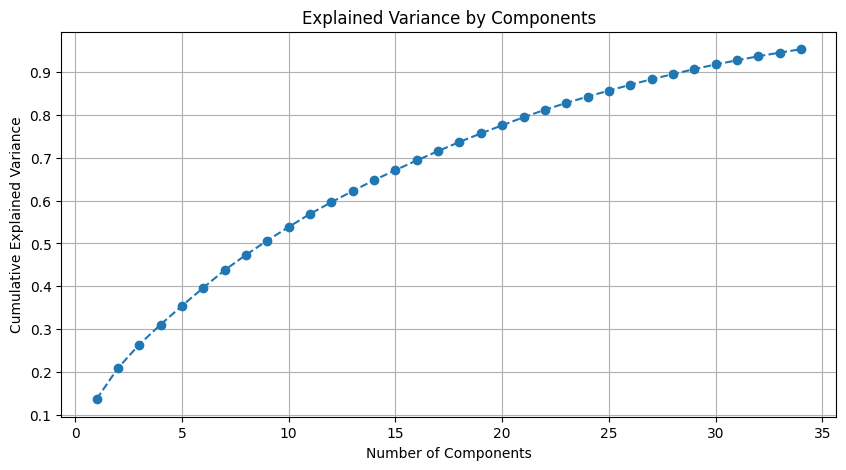

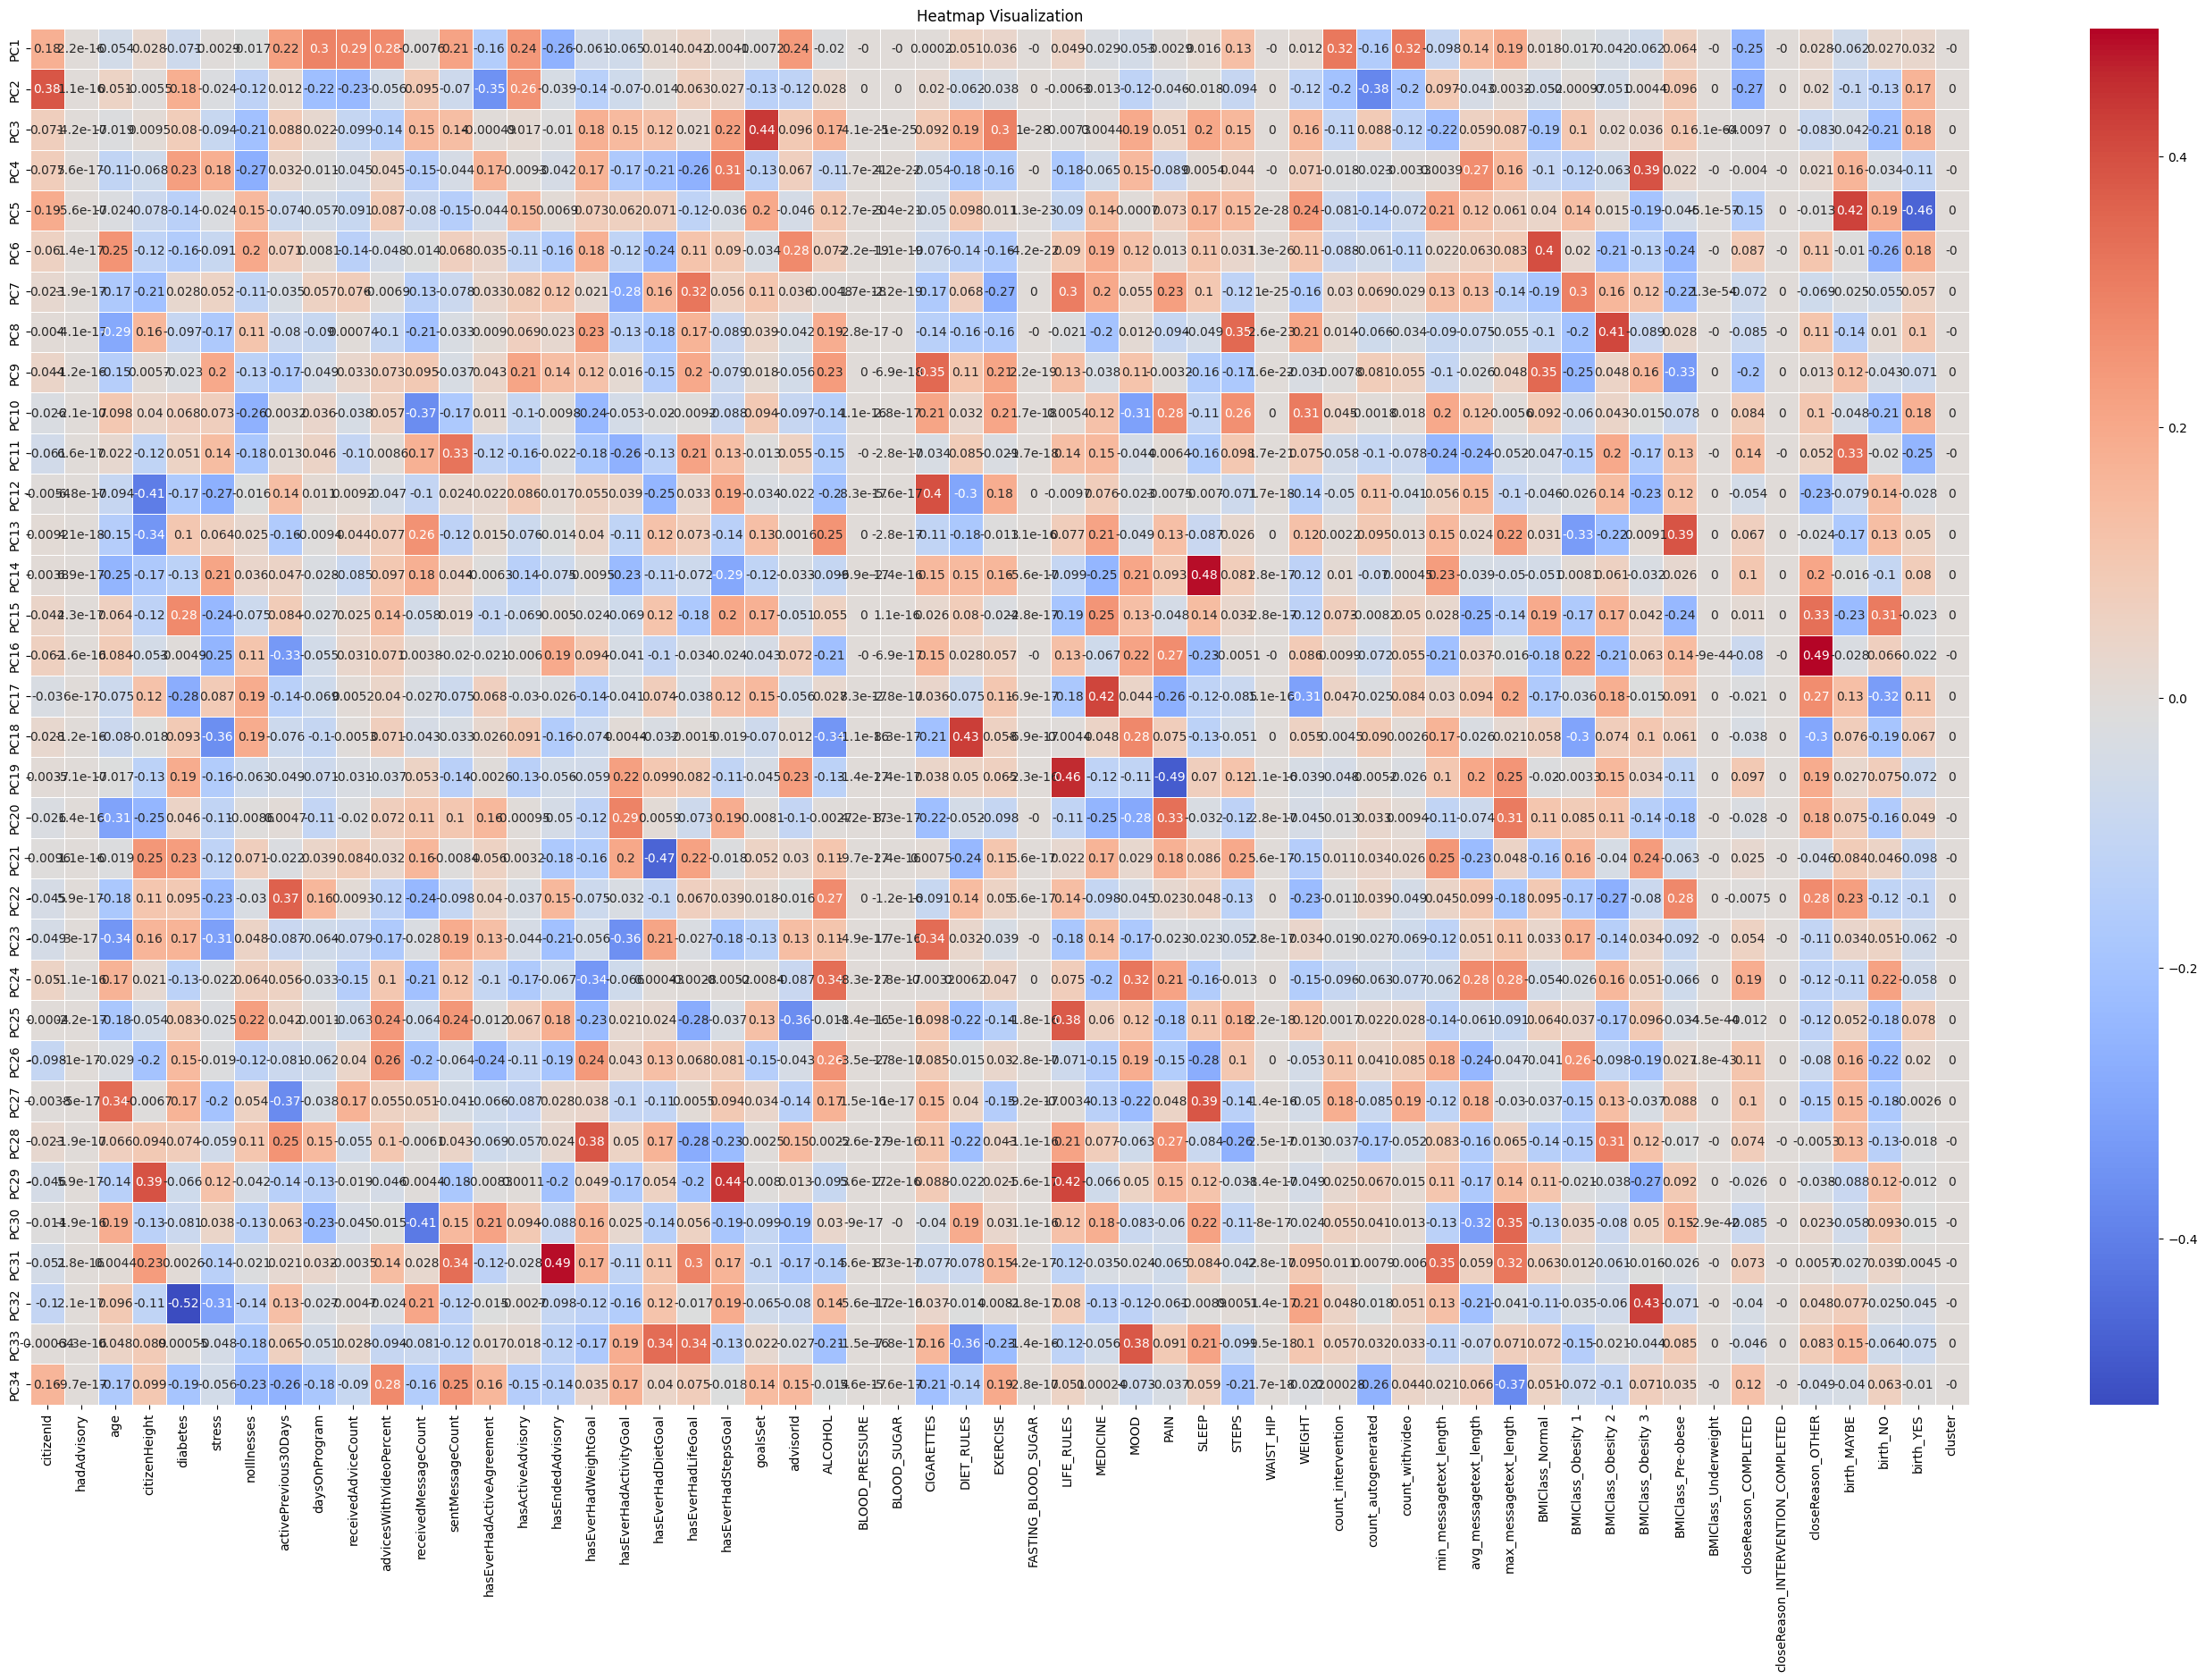

i='PC1'
i='PC2'
i='PC3'
i='PC4'
i='PC5'
i='PC6'
i='PC7'
i='PC8'
i='PC9'
i='PC10'
i='PC11'
i='PC12'
i='PC13'
i='PC14'
i='PC15'
i='PC16'
i='PC17'
i='PC18'
i='PC19'
i='PC20'
i='PC21'
i='PC22'
i='PC23'
i='PC24'
i='PC25'
i='PC26'
i='PC27'
i='PC28'
i='PC29'
i='PC30'
i='PC31'
i='PC32'
i='PC33'
i='PC34'
PC1: count_withvideo, count_intervention, daysOnProgram, receivedAdviceCount, advicesWithVideoPercent
PC2: citizenId, count_autogenerated, hasEverHadActiveAgreement, closeReason_COMPLETED, hasActiveAdvisory
PC3: goalsSet, EXERCISE, hasEverHadStepsGoal, min_messagetext_length, birth_NO
PC4: BMIClass_Obesity 3, hasEverHadStepsGoal, avg_messagetext_length, noIllnesses, hasEverHadLifeGoal
PC5: birth_YES, birth_MAYBE, WEIGHT, min_messagetext_length, goalsSet
PC6: BMIClass_Normal, advisorId, birth_NO, age, BMIClass_Pre-obese
PC7: hasEverHadLifeGoal, LIFE_RULES, BMIClass_Obesity 1, hasEverHadActivityGoal, EXERCISE
PC8: BMIClass_Obesity 2, STEPS, age, hasEverHadWeightGoal, WEIGHT
PC9: BMIClass_Normal, 

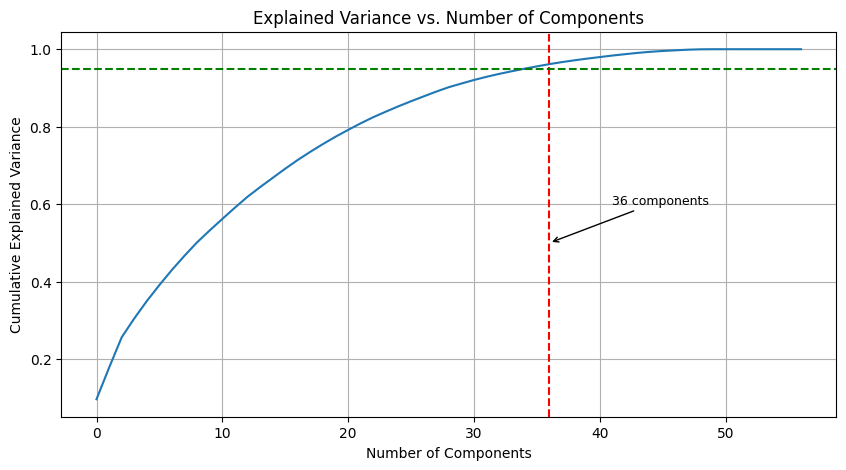

   Component  Explained Variance
0        PC1            0.096404
1        PC2            0.081397
2        PC3            0.078350
3        PC4            0.048719
4        PC5            0.045007
5        PC6            0.041359
6        PC7            0.039243
7        PC8            0.036522
8        PC9            0.034602
9       PC10            0.030647
10      PC11            0.029548
11      PC12            0.029163
12      PC13            0.028047
13      PC14            0.024901
14      PC15            0.023854
15      PC16            0.023791
16      PC17            0.022660
17      PC18            0.021042
18      PC19            0.019970
19      PC20            0.018915
20      PC21            0.017579
21      PC22            0.017023
22      PC23            0.015823
23      PC24            0.014282
24      PC25            0.013830
25      PC26            0.012995
26      PC27            0.012529
27      PC28            0.012338
28      PC29            0.011449
29      PC

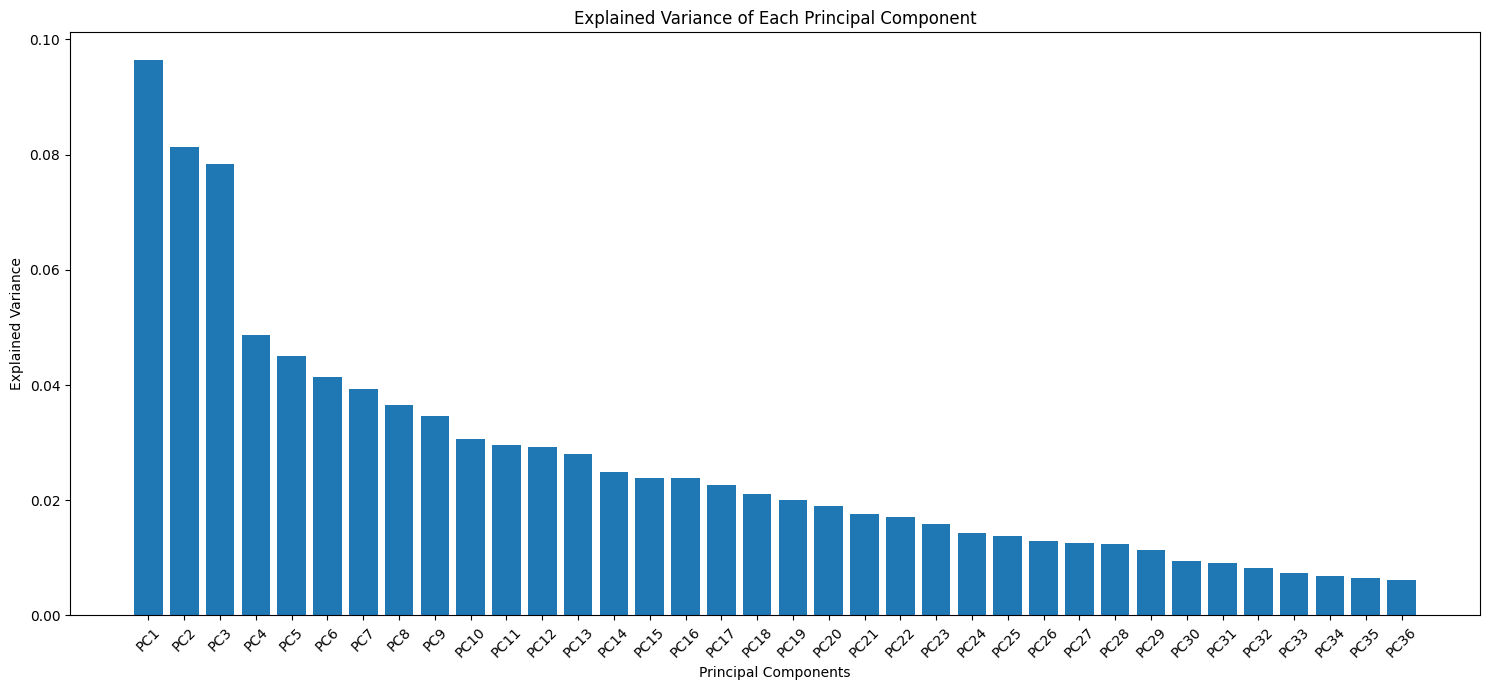

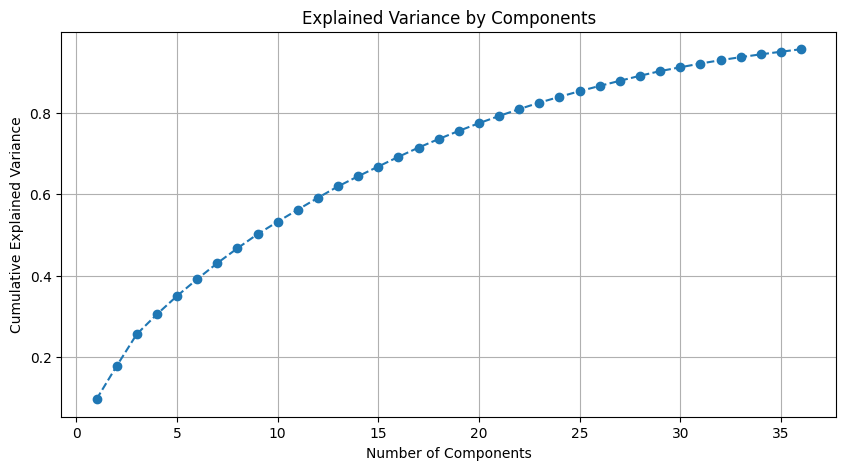

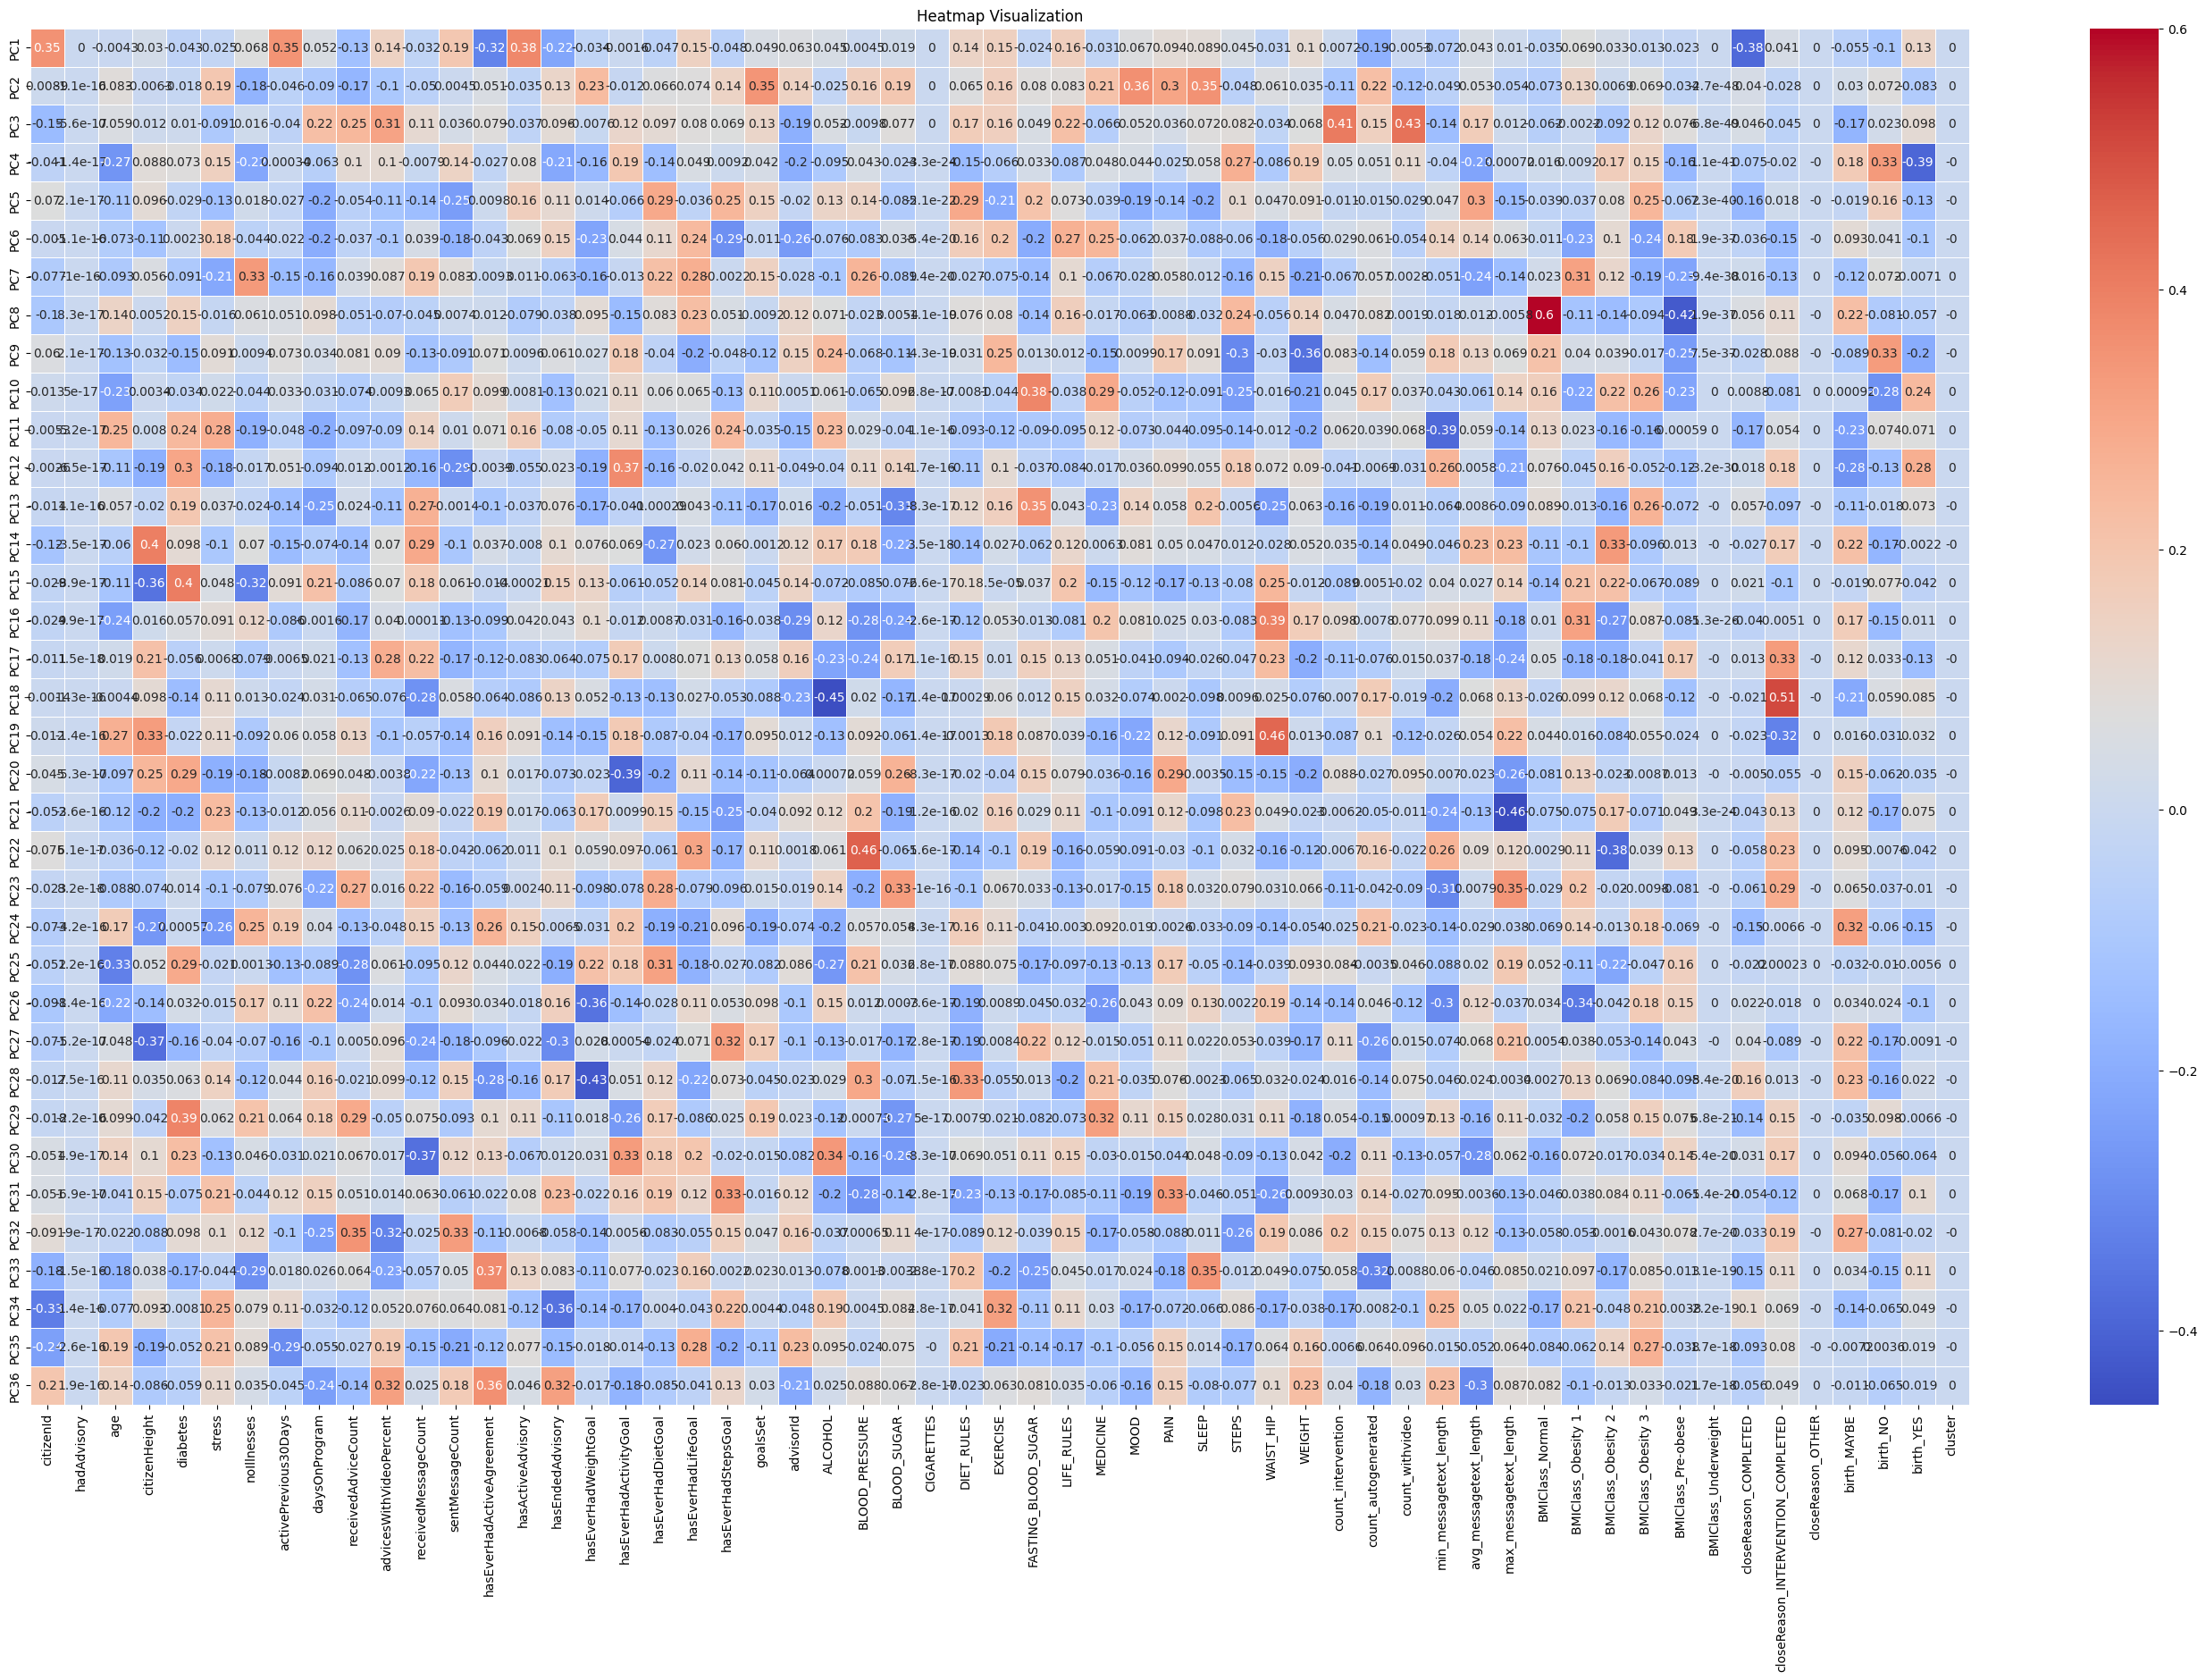

i='PC1'
i='PC2'
i='PC3'
i='PC4'
i='PC5'
i='PC6'
i='PC7'
i='PC8'
i='PC9'
i='PC10'
i='PC11'
i='PC12'
i='PC13'
i='PC14'
i='PC15'
i='PC16'
i='PC17'
i='PC18'
i='PC19'
i='PC20'
i='PC21'
i='PC22'
i='PC23'
i='PC24'
i='PC25'
i='PC26'
i='PC27'
i='PC28'
i='PC29'
i='PC30'
i='PC31'
i='PC32'
i='PC33'
i='PC34'
i='PC35'
i='PC36'
PC1: closeReason_COMPLETED, hasActiveAdvisory, citizenId, activePrevious30Days, hasEverHadActiveAgreement
PC2: MOOD, SLEEP, goalsSet, PAIN, hasEverHadWeightGoal
PC3: count_withvideo, count_intervention, advicesWithVideoPercent, receivedAdviceCount, daysOnProgram
PC4: birth_YES, birth_NO, age, STEPS, avg_messagetext_length
PC5: avg_messagetext_length, hasEverHadDietGoal, DIET_RULES, hasEverHadStepsGoal, BMIClass_Obesity 3
PC6: hasEverHadStepsGoal, LIFE_RULES, advisorId, MEDICINE, BMIClass_Obesity 3
PC7: noIllnesses, BMIClass_Obesity 1, hasEverHadLifeGoal, BLOOD_PRESSURE, avg_messagetext_length
PC8: BMIClass_Normal, BMIClass_Pre-obese, STEPS, hasEverHadLifeGoal, birth_MAYBE
PC9:

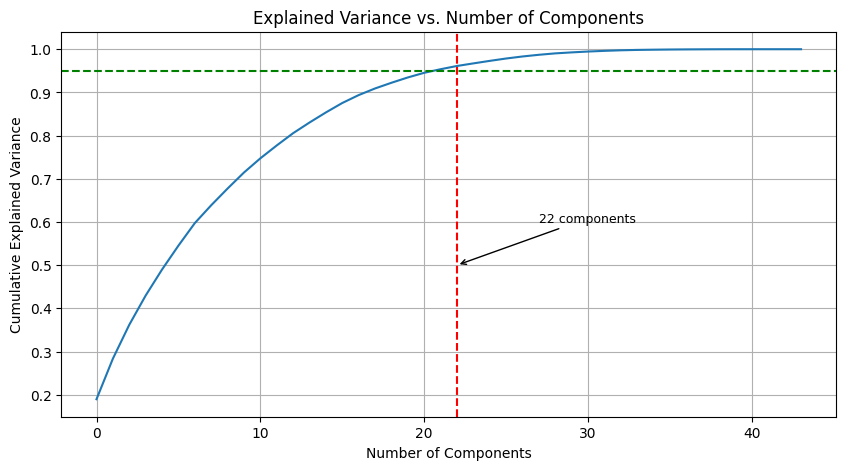

   Component  Explained Variance
0        PC1            0.189598
1        PC2            0.093952
2        PC3            0.078424
3        PC4            0.067731
4        PC5            0.060210
5        PC6            0.055320
6        PC7            0.052161
7        PC8            0.041323
8        PC9            0.038718
9       PC10            0.037087
10      PC11            0.032838
11      PC12            0.029817
12      PC13            0.028422
13      PC14            0.024690
14      PC15            0.023348
15      PC16            0.021848
16      PC17            0.018301
17      PC18            0.015360
18      PC19            0.013179
19      PC20            0.012305
20      PC21            0.010788
21      PC22            0.008291


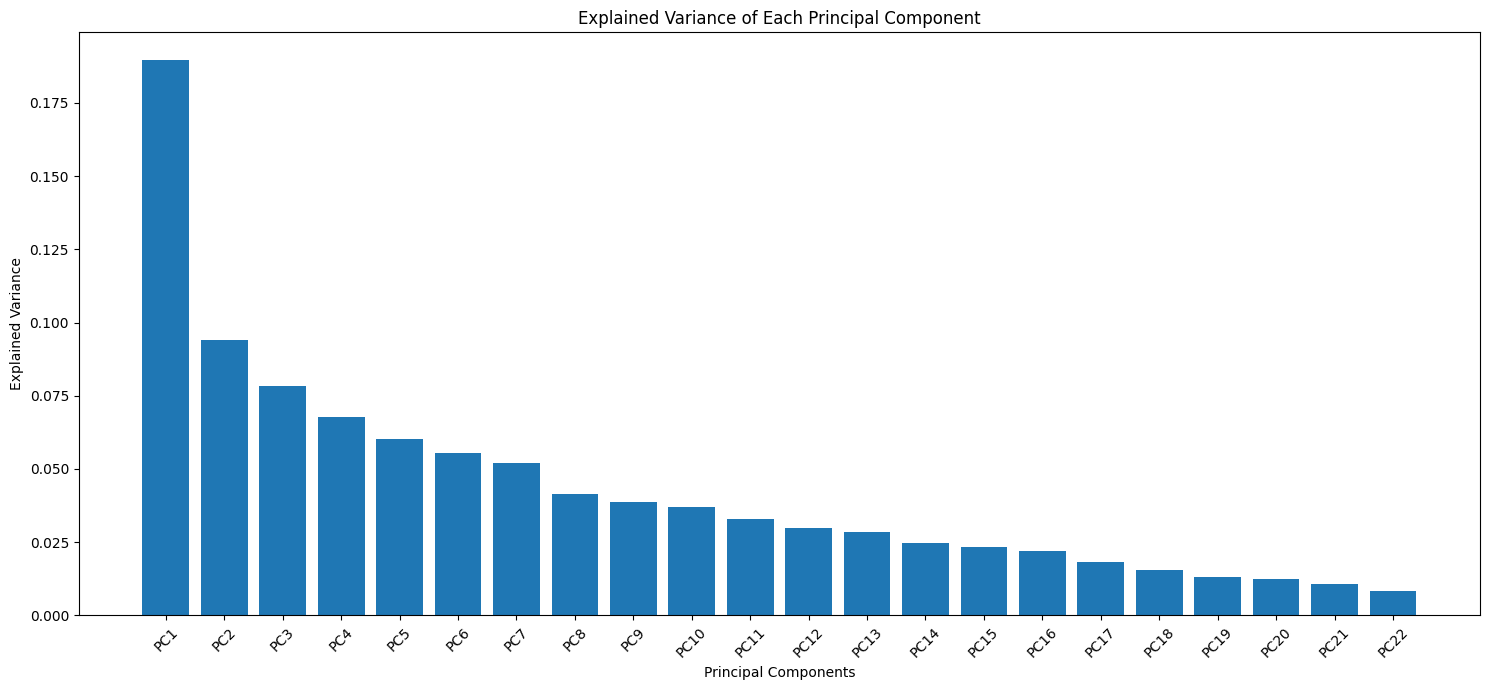

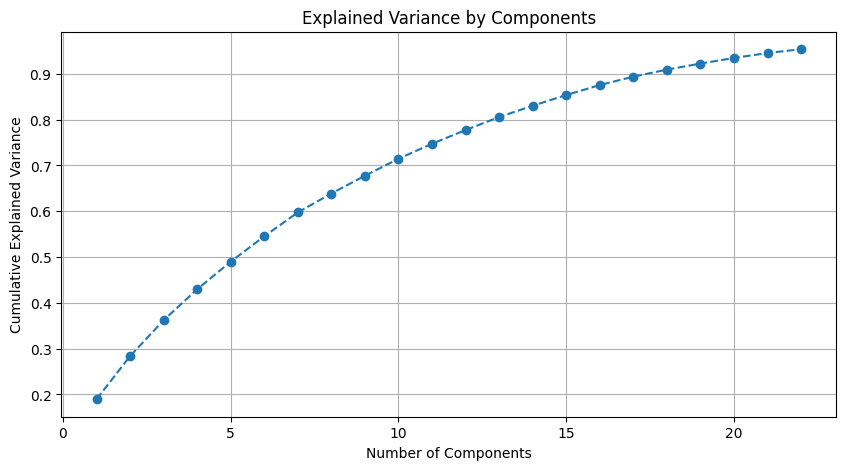

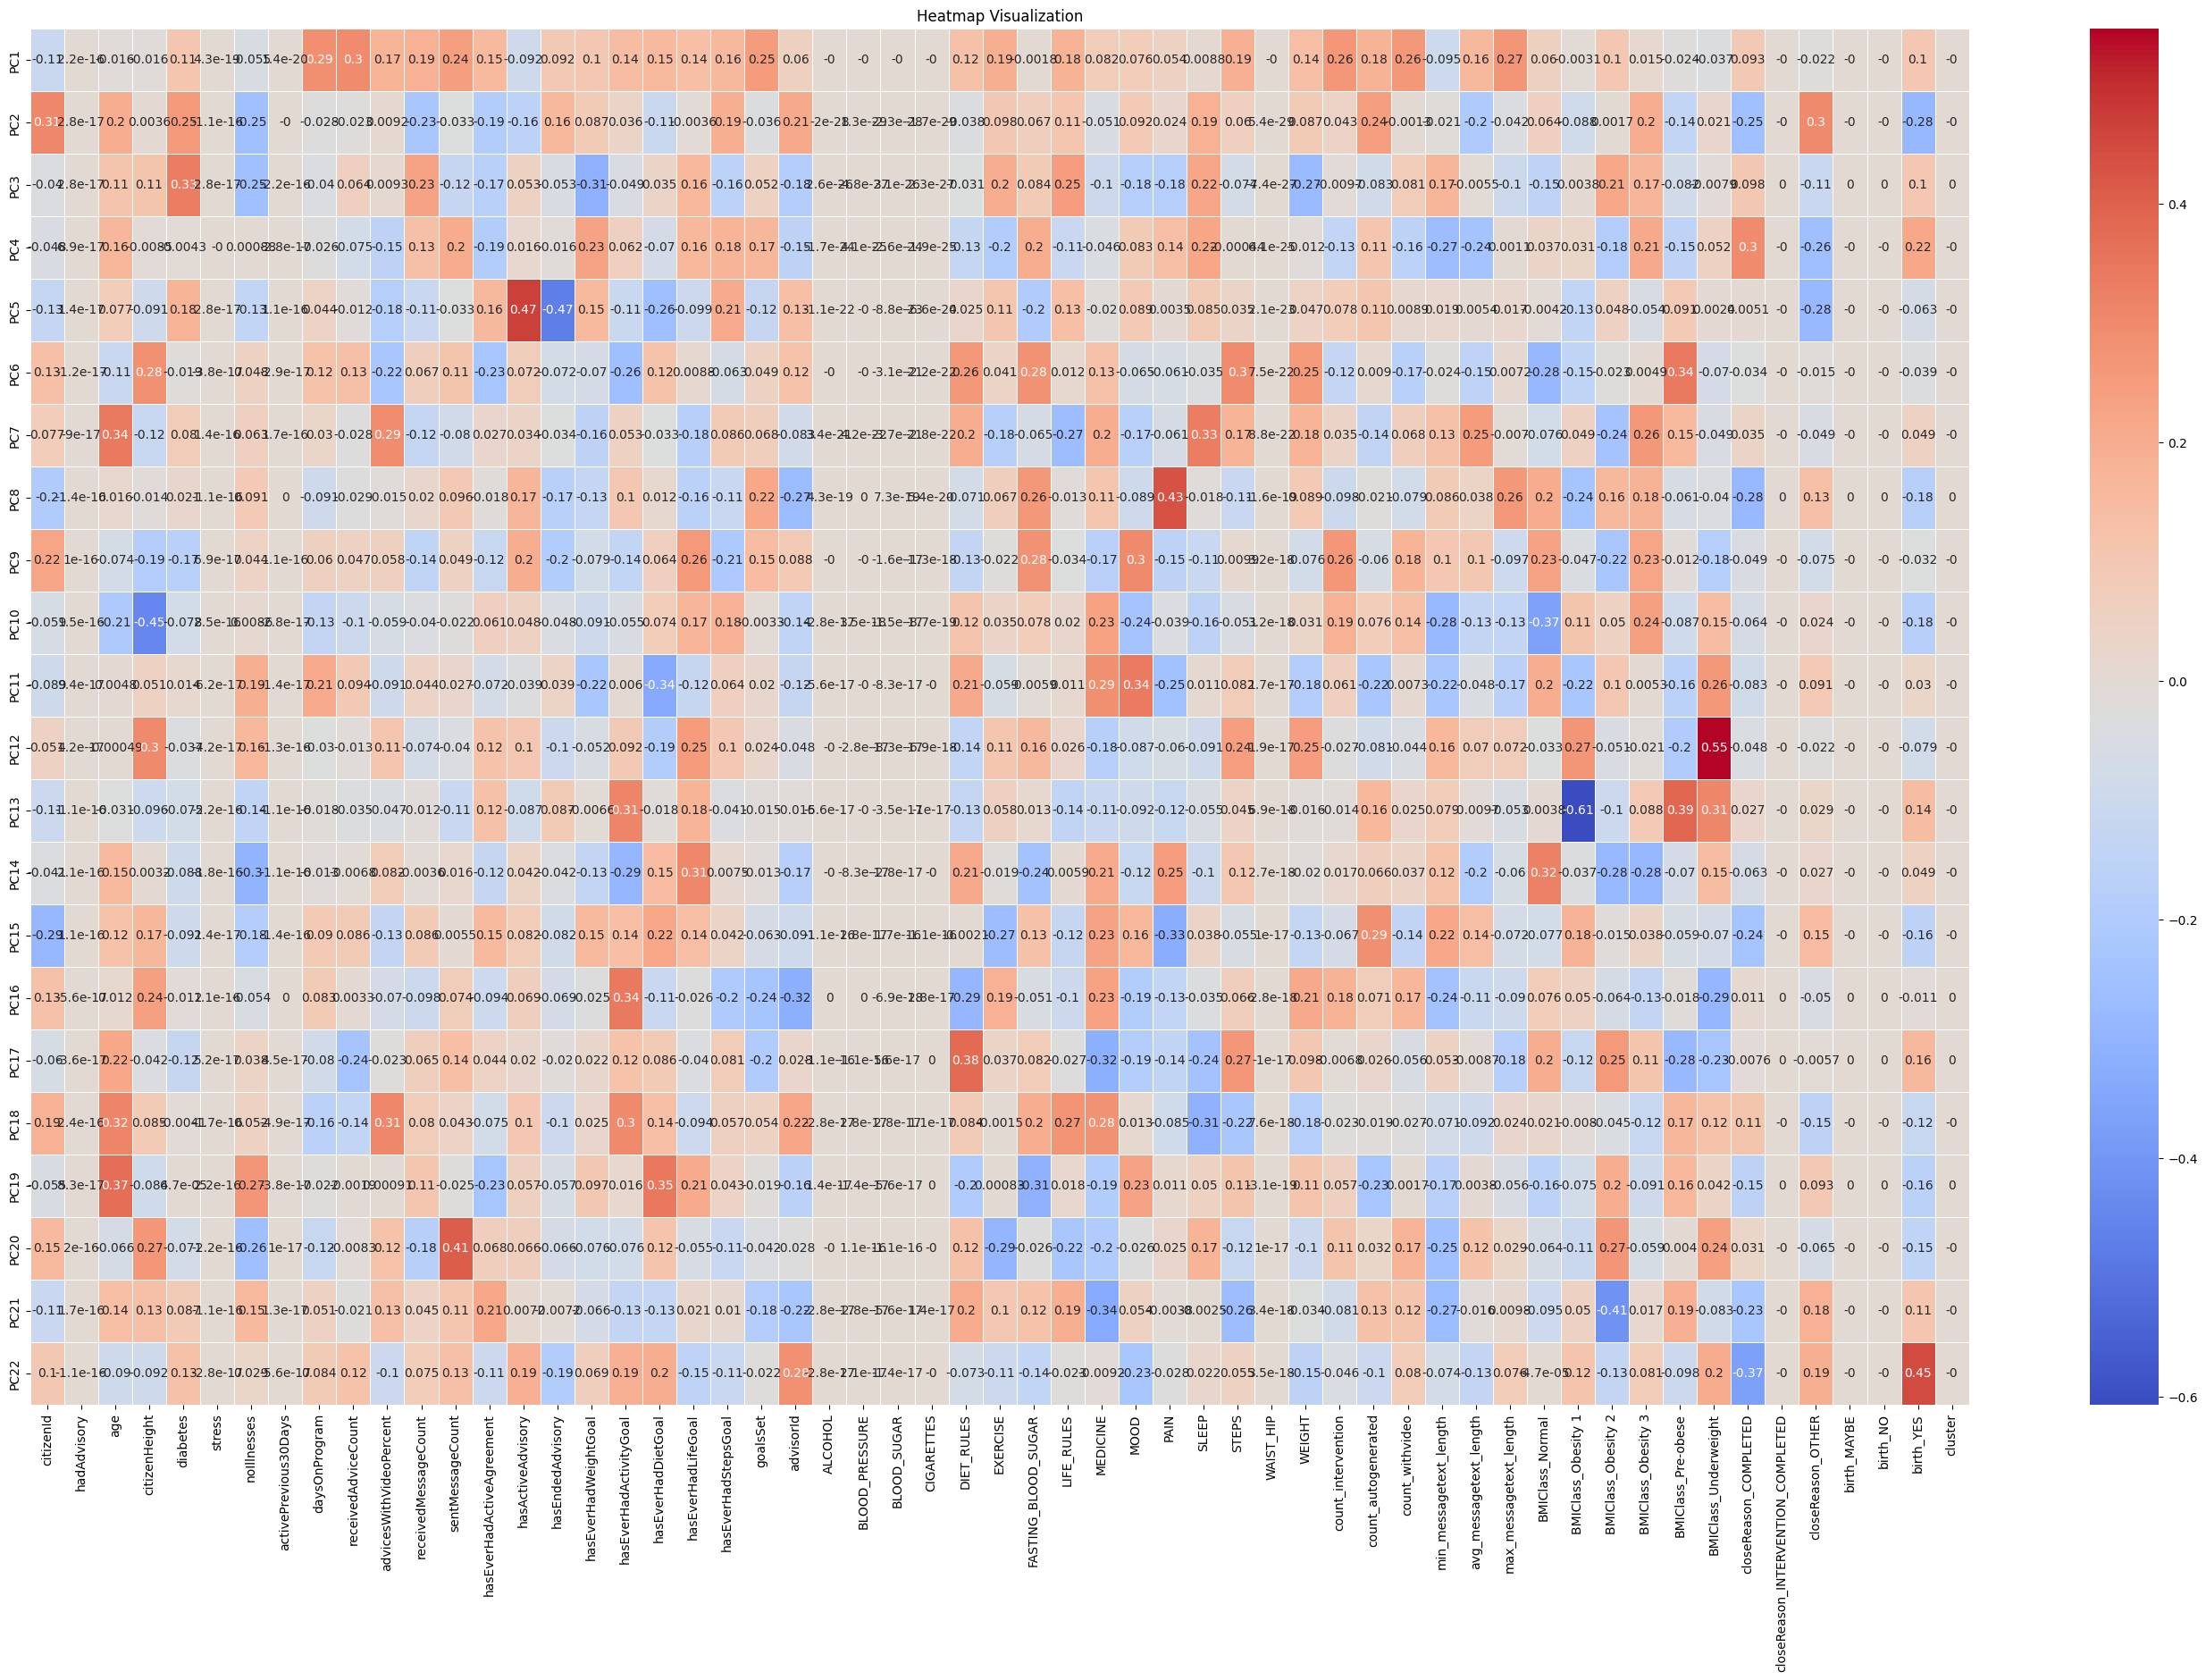

i='PC1'
i='PC2'
i='PC3'
i='PC4'
i='PC5'
i='PC6'
i='PC7'
i='PC8'
i='PC9'
i='PC10'
i='PC11'
i='PC12'
i='PC13'
i='PC14'
i='PC15'
i='PC16'
i='PC17'
i='PC18'
i='PC19'
i='PC20'
i='PC21'
i='PC22'
PC1: receivedAdviceCount, daysOnProgram, max_messagetext_length, count_intervention, count_withvideo
PC2: citizenId, closeReason_OTHER, birth_YES, diabetes, noIllnesses
PC3: diabetes, hasEverHadWeightGoal, WEIGHT, noIllnesses, LIFE_RULES
PC4: closeReason_COMPLETED, min_messagetext_length, closeReason_OTHER, avg_messagetext_length, hasEverHadWeightGoal
PC5: hasActiveAdvisory, hasEndedAdvisory, closeReason_OTHER, hasEverHadDietGoal, hasEverHadStepsGoal
PC6: BMIClass_Pre-obese, STEPS, BMIClass_Normal, citizenHeight, FASTING_BLOOD_SUGAR
PC7: age, SLEEP, advicesWithVideoPercent, LIFE_RULES, BMIClass_Obesity 3
PC8: PAIN, closeReason_COMPLETED, advisorId, max_messagetext_length, FASTING_BLOOD_SUGAR
PC9: MOOD, FASTING_BLOOD_SUGAR, count_intervention, hasEverHadLifeGoal, BMIClass_Normal
PC10: citizenHeight, B

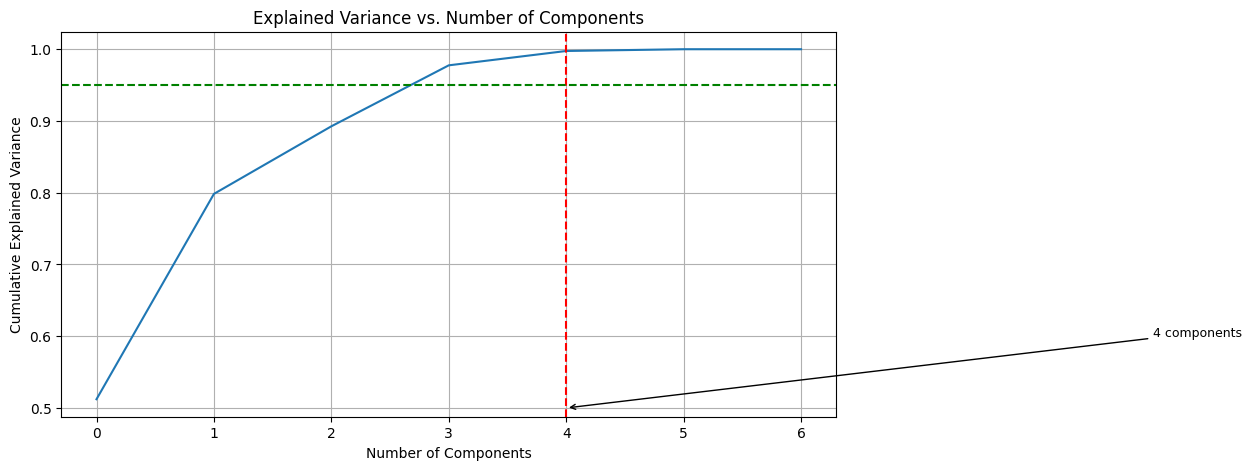

  Component  Explained Variance
0       PC1            0.512188
1       PC2            0.286185
2       PC3            0.094204
3       PC4            0.084978


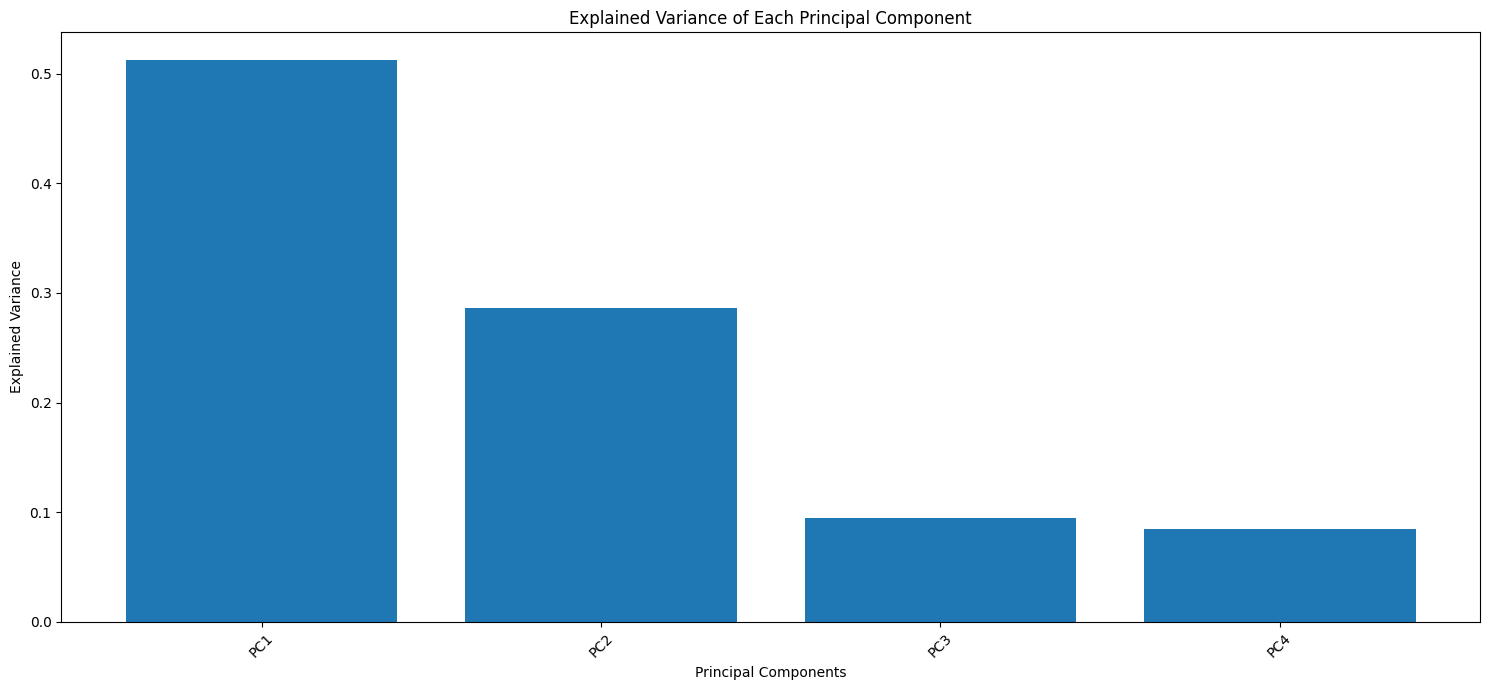

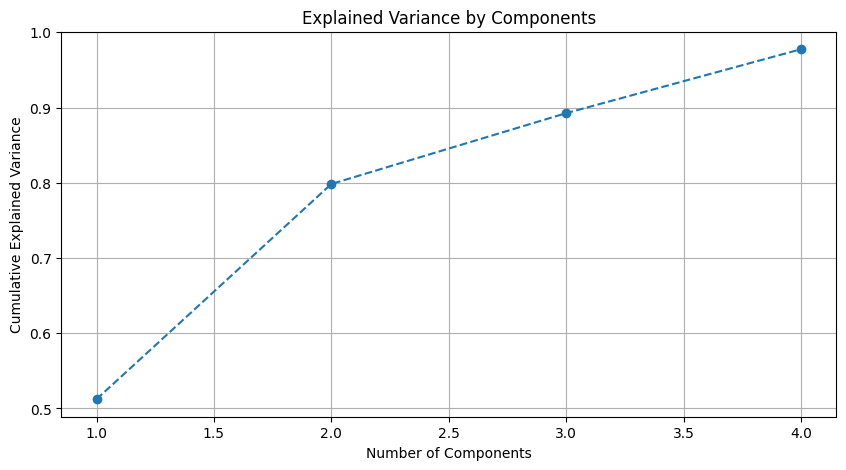

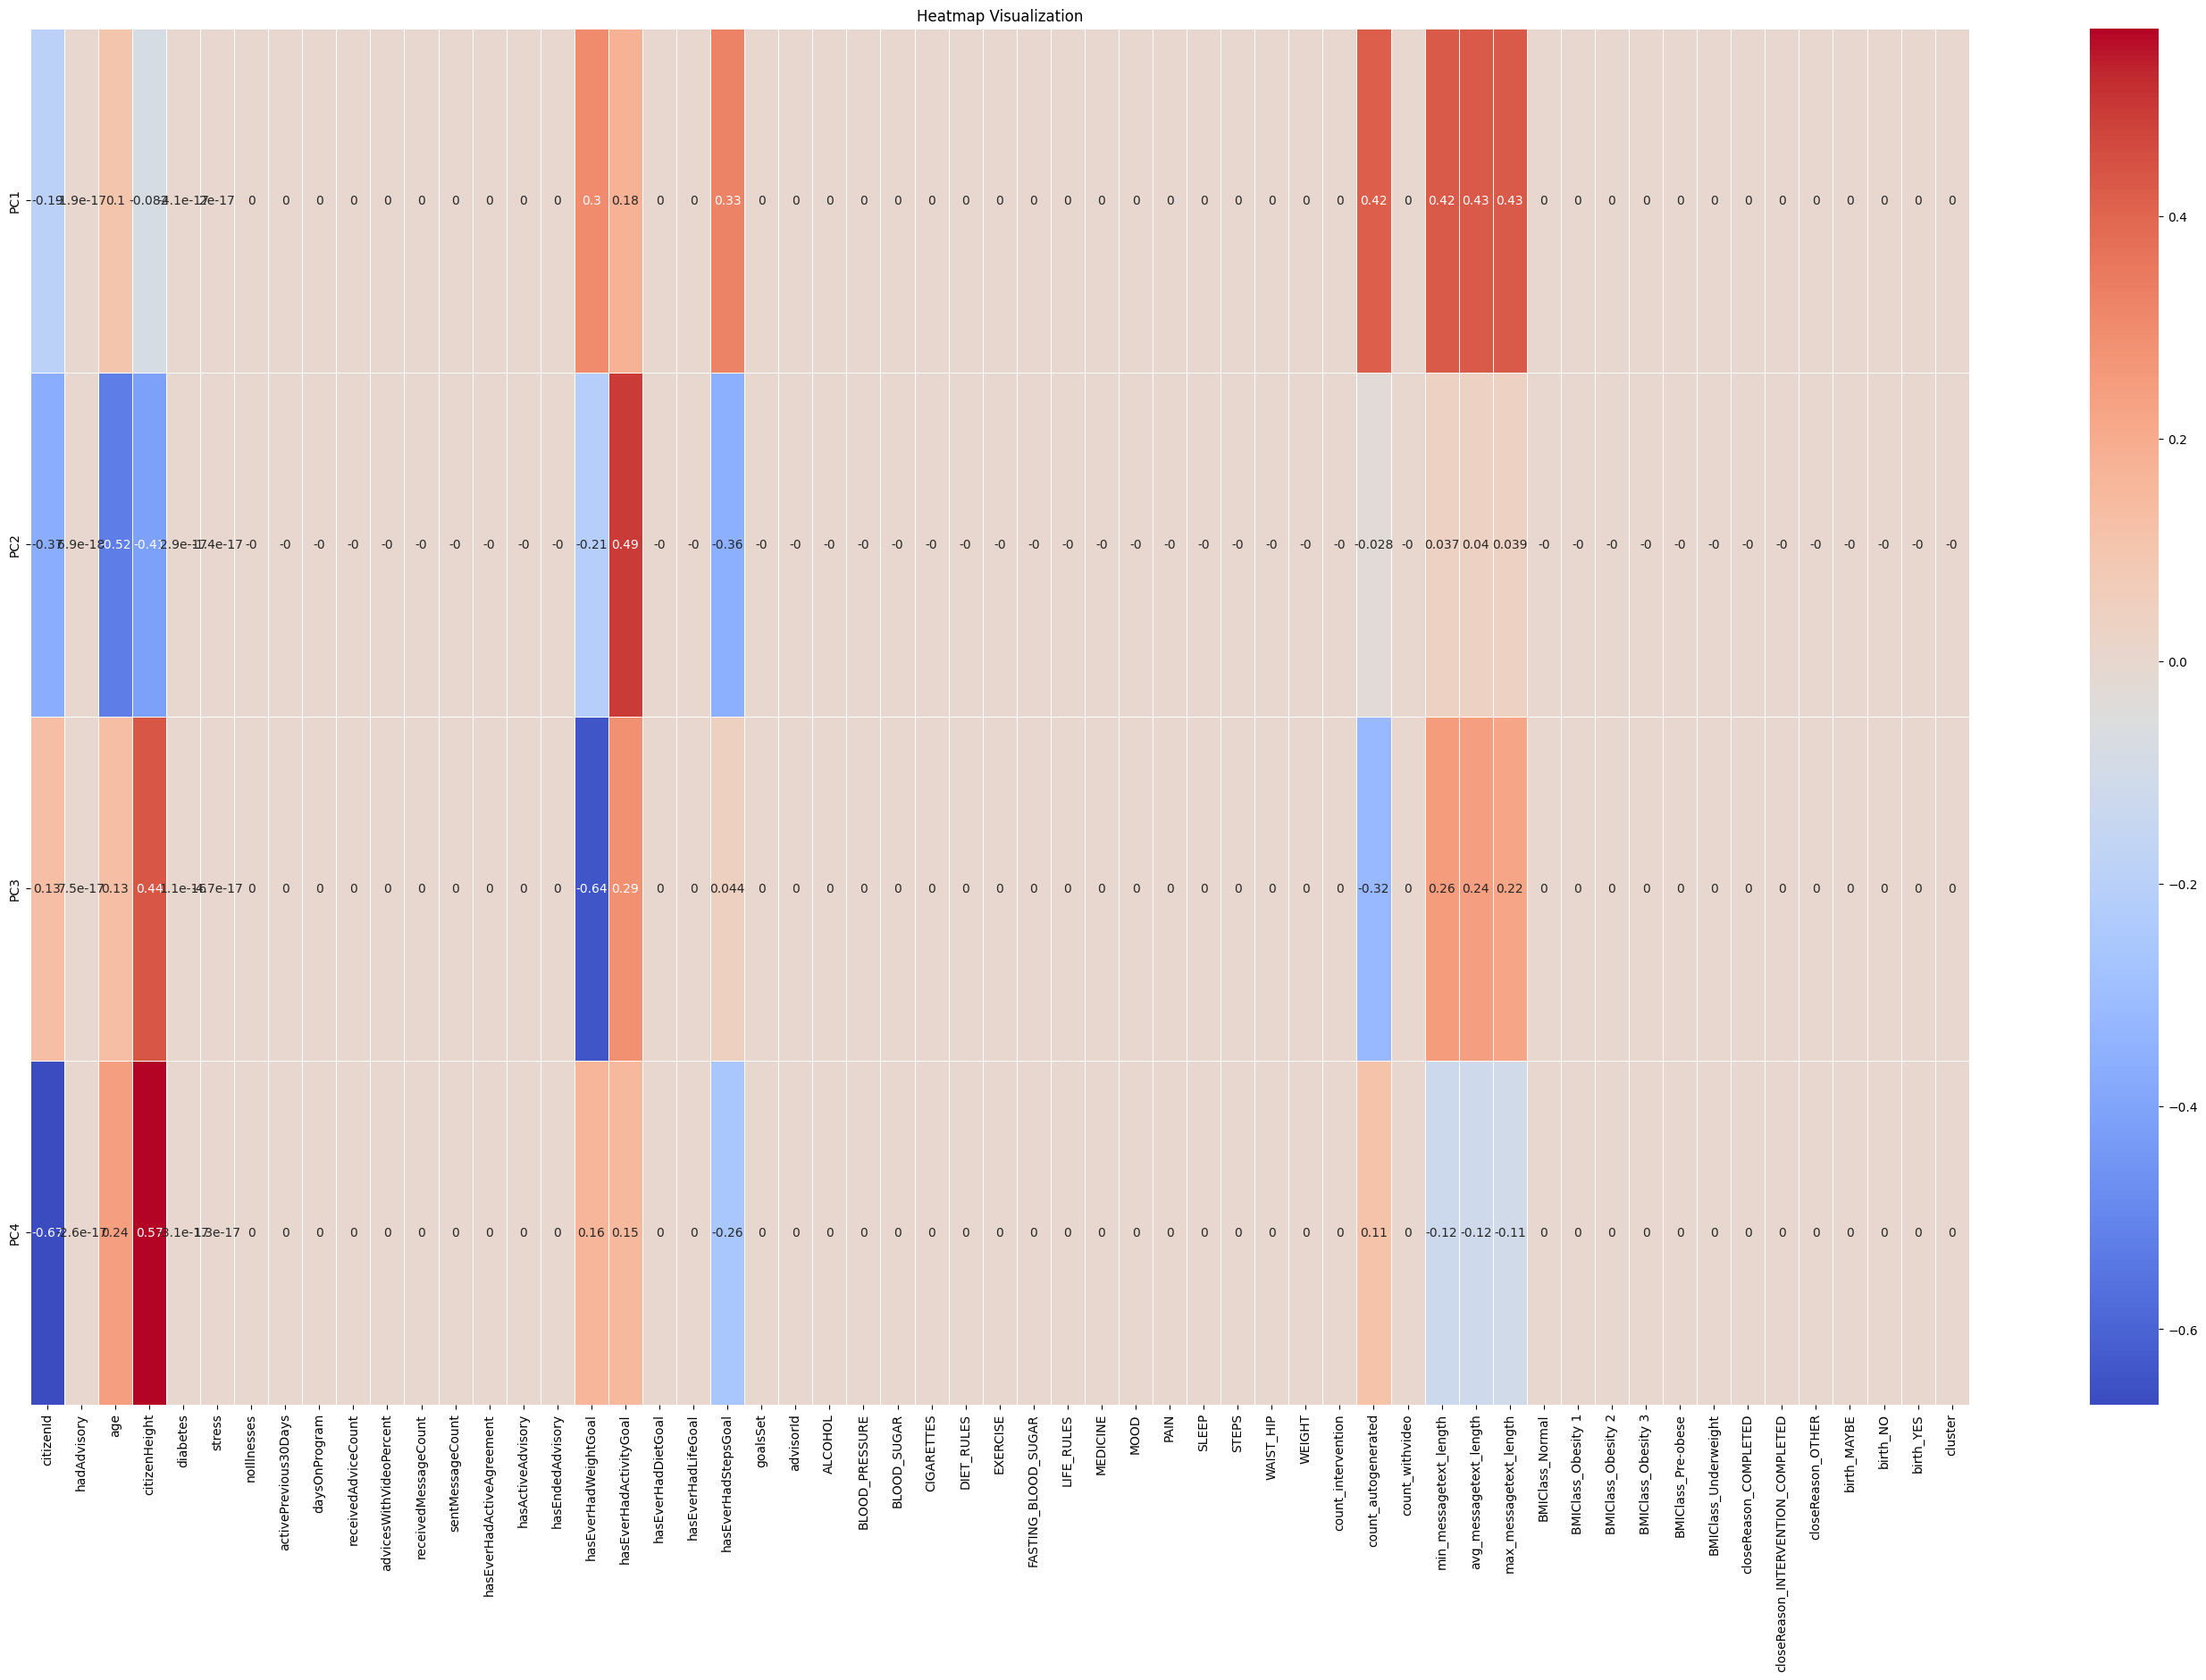

i='PC1'
i='PC2'
i='PC3'
i='PC4'
PC1: max_messagetext_length, avg_messagetext_length, min_messagetext_length, count_autogenerated, hasEverHadStepsGoal
PC2: age, hasEverHadActivityGoal, citizenHeight, citizenId, hasEverHadStepsGoal
PC3: hasEverHadWeightGoal, citizenHeight, count_autogenerated, hasEverHadActivityGoal, min_messagetext_length
PC4: citizenId, citizenHeight, hasEverHadStepsGoal, age, hasEverHadWeightGoal
TOP 10 features
citizenHeight             1.501062
citizenId                 1.362979
hasEverHadWeightGoal      1.316920
hasEverHadActivityGoal    1.115989
age                       1.002358
hasEverHadStepsGoal       0.986227
count_autogenerated       0.878389
min_messagetext_length    0.840083
avg_messagetext_length    0.823725
max_messagetext_length    0.795950
dtype: float64


In [7]:
features_impact_of_components_for_each_cluster = []

for i, cluster_path in enumerate(cluster_paths):
    print()
    print(f"Cluster {i+1}: {cluster_path}")
    cluster_data, features = step_0_load(cluster_path)
    best_num_components = get_best_number_of_components(cluster_data)
    features_impact = step_3_cluster_analysis(cluster_data, features, best_num_components)
    features_impact_of_components_for_each_cluster.append(features_impact)

In [8]:
for i, features_impact in enumerate(features_impact_of_components_for_each_cluster):
    print(f"Cluster {i+1}")
    print(features_impact[:10])
    print()

Cluster 1
MOOD                      3.407230
PAIN                      3.346118
age                       3.115144
BMIClass_Obesity 2        3.108359
birth_MAYBE               3.085387
hasEverHadWeightGoal      3.066740
WEIGHT                    3.042865
citizenHeight             2.958945
hasEverHadActivityGoal    2.888460
min_messagetext_length    2.852605
dtype: float64

Cluster 2
stress                    4.494799
ALCOHOL                   4.458467
hasEverHadWeightGoal      4.440678
MOOD                      4.413246
citizenHeight             4.393598
avg_messagetext_length    4.374963
diabetes                  4.364111
max_messagetext_length    4.342074
age                       4.325323
MEDICINE                  4.319665
dtype: float64

Cluster 3
ALCOHOL                   4.712082
receivedMessageCount      4.654009
max_messagetext_length    4.564825
hasEndedAdvisory          4.511918
age                       4.424106
hasEverHadActivityGoal    4.380477
hasEverHadStepsGoal       4.

# load df

In [9]:


# Convert list of series to DataFrame
df = pd.concat(features_impact_of_components_for_each_cluster, axis=1)

# Rename columns for clarity
df.columns = [f'Cluster_{i+1}' for i in range(len(features_impact_of_components_for_each_cluster))]

# Transpose the DataFrame
df_transposed = df.transpose()

df_transposed

MOOD      PAIN       age  BMIClass_Obesity 2  birth_MAYBE  \
Cluster_1  3.407230  3.346118  3.115144            3.108359     3.085387   
Cluster_2  4.413246  4.144798  4.325323            4.256871     3.685105   
Cluster_3  3.336924  3.899956  4.424106            4.202048     4.258381   
Cluster_4  3.107981  2.573573  2.841661            3.174451     0.000000   
Cluster_5  0.000000  0.000000  1.002358            0.000000     0.000000   

           hasEverHadWeightGoal    WEIGHT  citizenHeight  \
Cluster_1              3.066740  3.042865       2.958945   
Cluster_2              4.440678  3.848027       4.393598   
Cluster_3              3.882622  4.039403       4.370772   
Cluster_4              2.342015  2.672465       2.834007   
Cluster_5              1.316920  0.000000       1.501062   

           hasEverHadActivityGoal  min_messagetext_length  ...        stress  \
Cluster_1                2.888460                2.852605  ...  1.514414e-15   
Cluster_2                4.122635                4.314698  ...  4.494799e+00   
Cluster_3                4.380477                4.349839  ...  4.319269e+00   
Cluster_4                3.018443                3.122970  ...  2.212206e-15   
Cluster_5                1.115989                0.840083  ...  9.437187e-17   

           hasEndedAdvisory    CIGARETTES   BLOOD_SUGAR       ALCOHOL  \
Cluster_1      1.046038e-15  6.354521e-16  3.812888e-16  2.386364e-16   
Cluster_2      3.584974e+00  4.028226e+00  2.375274e-15  4.458467e+00   
Cluster_3      4.511918e+00  1.636021e-15  4.338948e+00  4.712082e+00   
Cluster_4      2.179163e+00  1.832849e-16  7.527414e-16  4.584042e-16   
Cluster_5      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              WAIST_HIP  closeReason_OTHER  \
Cluster_1  5.436449e-17           0.000000   
Cluster_2  7.029986e-16           3.993335   
Cluster_3  4.291349e+00           0.000000   
Cluster_4  1.000132e-16           2.331507   
Cluster_5  0.000000e+00           0.000000   

           closeReason_INTERVENTION_COMPLETED  BMIClass_Underweight  cluster  
Cluster_1                            0.000000          0.000000e+00      0.0  
Cluster_2                            0.000000          3.183750e-42      0.0  
Cluster_3                            4.235633          3.991223e-18      0.0  
Cluster_4                            0.000000          3.144057e+00      0.0  
Cluster_5                            0.000000          0.000000e+00      0.0  

[5 rows x 57 columns]

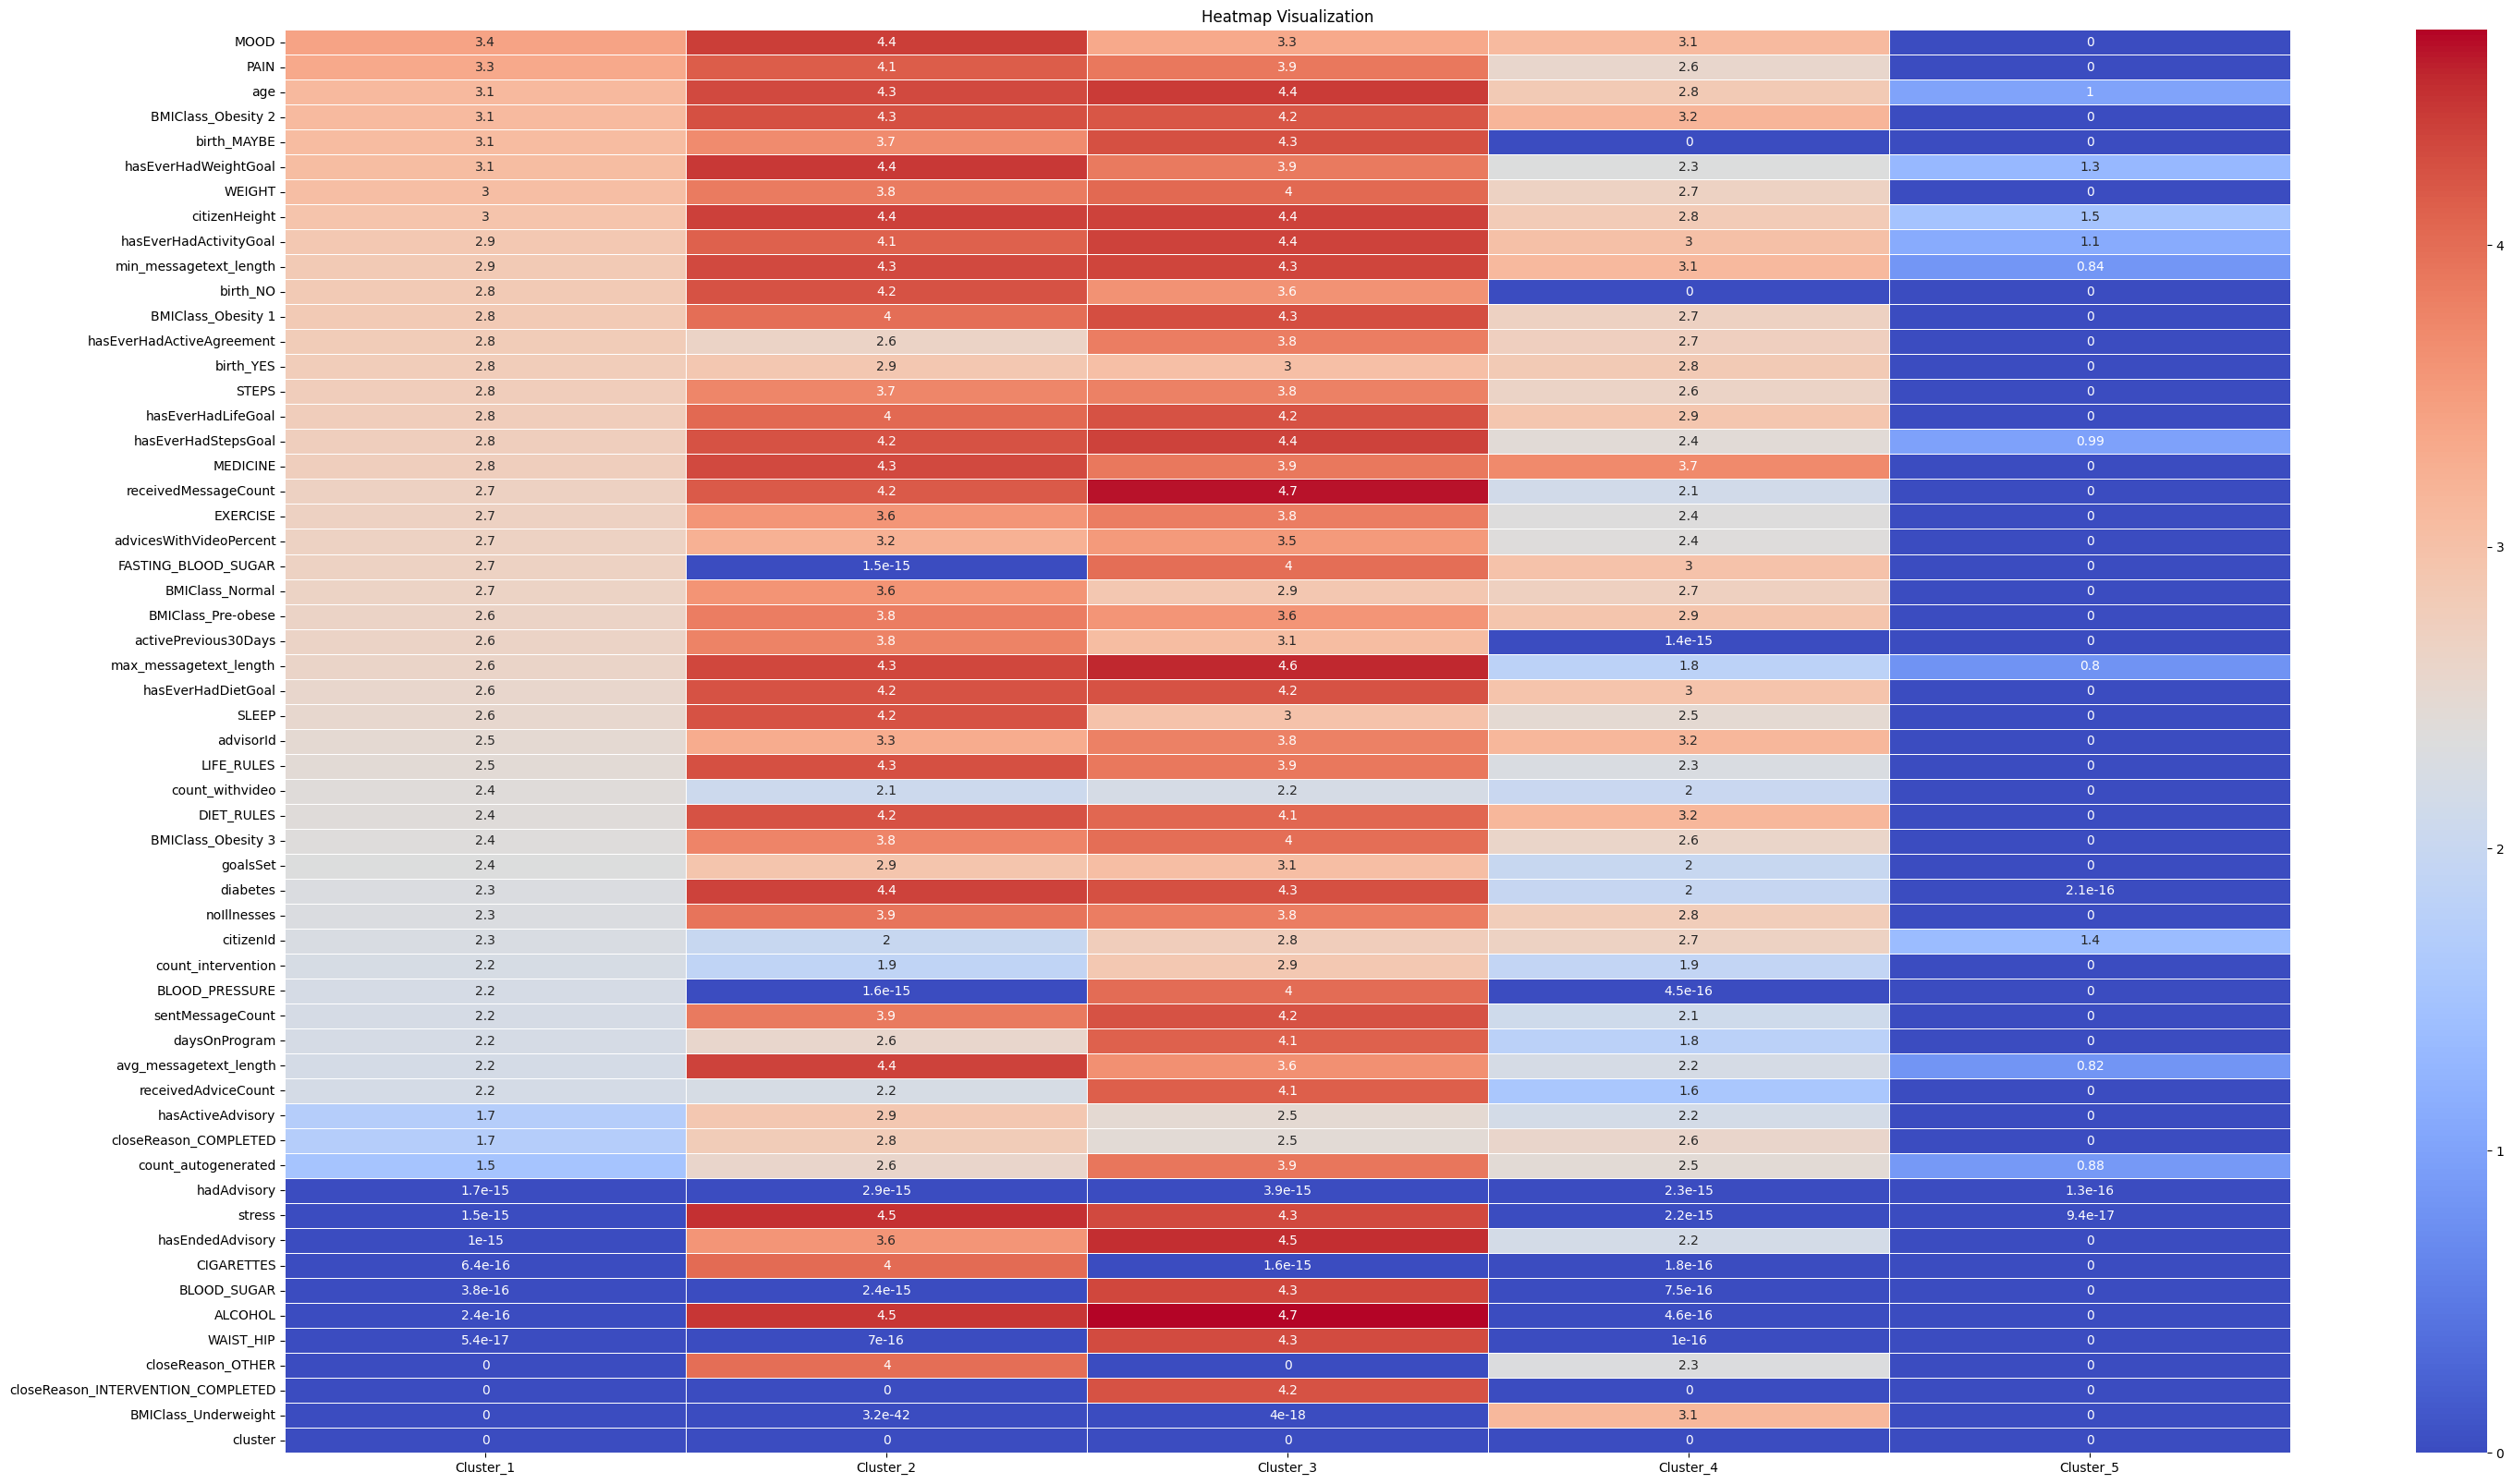

In [10]:
# Plot the heatmap
plt.figure(figsize=(35, 20))
sns.heatmap(df_transposed.T, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Visualization')
plt.show()

<ipython-input-29-157ebe1f8db4>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=tick_font_size)


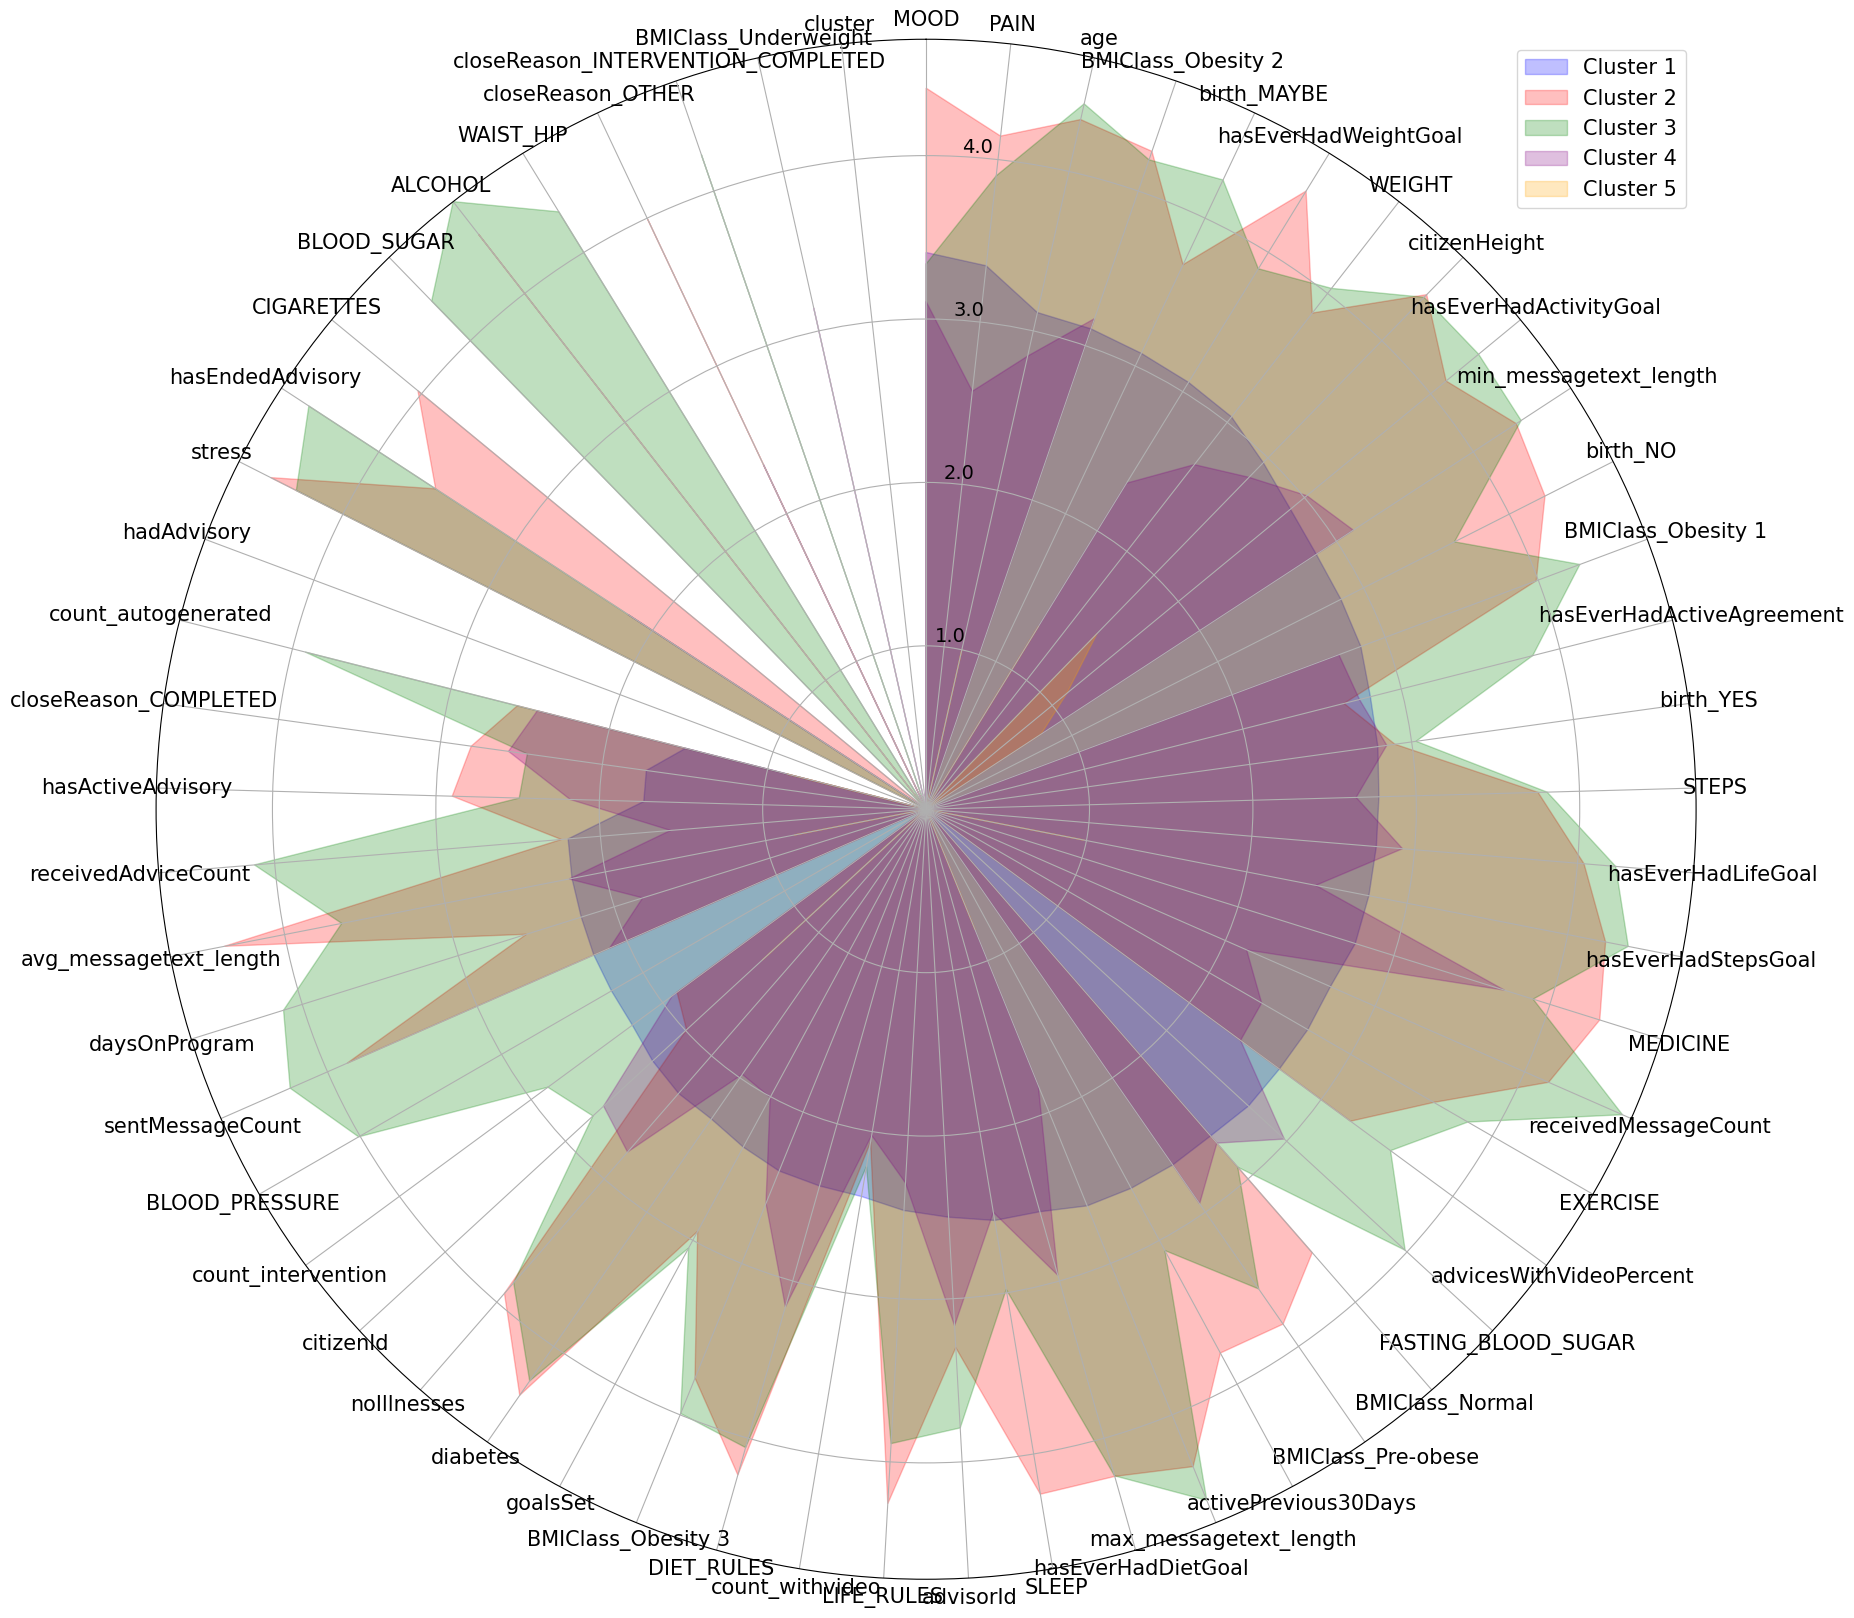

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# # Data
# labels = ['A', 'B', 'C']
# values = [
#     [1, 2, 3],
#     [5, 6, 2],
#     [4, 4, 4],
#     [2, 3, 5],
#     [3, 2, 1]
# ]

# Extract labels and values from DataFrame
labels = df_transposed.columns.tolist()
values = df_transposed.values.tolist()

# Set up the radar chart
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(polar=True))

colors = ['blue', 'red', 'green', 'purple', 'orange']

for i, val in enumerate(values):
    val += val[:1]
    ax.fill(angles, val, color=colors[i], alpha=0.25)

# Improve the appearance and add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)

# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(labels)
# ax.set_ylim(0, max([max(v) for v in values]))

# # Add legend
# ax.legend([f'Cluster {i+1}' for i in range(len(values))], loc='upper right')

# plt.show()


# Set the font size here
label_font_size = 15  # You can adjust this size to your preference
tick_font_size = 14  # And also adjust this size accordingly

# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(labels)
# ax.set_ylim(0, max([max(v) for v in values]))

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=label_font_size)
ax.set_yticklabels(ax.get_yticks(), fontsize=tick_font_size)

# # Add legend
# ax.legend([f'Cluster {i+1}' for i in range(len(values))], loc='upper right')

# plt.show()

ax.set_ylim(0, max([max(v) for v in values]))

# Add legend with a larger font
legend_font_size = 15  # Adjust legend font size if necessary
ax.legend([f'Cluster {i+1}' for i in range(len(values))], loc='upper right', fontsize=legend_font_size)

plt.show()


# Top 10 features for each clusters

In [16]:
top_10_features_impact_of_components_for_each_cluster = []
for i, features_impact in enumerate(features_impact_of_components_for_each_cluster):
    print(f"Cluster {i+1}")
    # sorted_features_impact = sorted(features_impact, reverse=True)
    sorted_features_impact = features_impact.nlargest(5)
    top_10_features_impact_of_components_for_each_cluster.append(sorted_features_impact)
    print(sorted_features_impact)
    print()

Cluster 1
MOOD                  3.407230
PAIN                  3.346118
age                   3.115144
BMIClass_Obesity 2    3.108359
birth_MAYBE           3.085387
dtype: float64

Cluster 2
stress                  4.494799
ALCOHOL                 4.458467
hasEverHadWeightGoal    4.440678
MOOD                    4.413246
citizenHeight           4.393598
dtype: float64

Cluster 3
ALCOHOL                   4.712082
receivedMessageCount      4.654009
max_messagetext_length    4.564825
hasEndedAdvisory          4.511918
age                       4.424106
dtype: float64

Cluster 4
MEDICINE                3.708944
BMIClass_Obesity 2      3.174451
advisorId               3.164757
DIET_RULES              3.164113
BMIClass_Underweight    3.144057
dtype: float64

Cluster 5
citizenHeight             1.501062
citizenId                 1.362979
hasEverHadWeightGoal      1.316920
hasEverHadActivityGoal    1.115989
age                       1.002358
dtype: float64



In [17]:
# Convert list of series to DataFrame
top_10_df = pd.concat(top_10_features_impact_of_components_for_each_cluster, axis=1)

# Rename columns for clarity
top_10_df.columns = [f'Cluster{i+1}' for i in range(len(top_10_features_impact_of_components_for_each_cluster))]

# Transpose the DataFrame
top_10_df_transposed = top_10_df.transpose()

top_10_df_transposed

MOOD      PAIN       age  BMIClass_Obesity 2  birth_MAYBE  \
Cluster1  3.407230  3.346118  3.115144            3.108359     3.085387   
Cluster2  4.413246       NaN       NaN                 NaN          NaN   
Cluster3       NaN       NaN  4.424106                 NaN          NaN   
Cluster4       NaN       NaN       NaN            3.174451          NaN   
Cluster5       NaN       NaN  1.002358                 NaN          NaN   

            stress   ALCOHOL  hasEverHadWeightGoal  citizenHeight  \
Cluster1       NaN       NaN                   NaN            NaN   
Cluster2  4.494799  4.458467              4.440678       4.393598   
Cluster3       NaN  4.712082                   NaN            NaN   
Cluster4       NaN       NaN                   NaN            NaN   
Cluster5       NaN       NaN              1.316920       1.501062   

          receivedMessageCount  max_messagetext_length  hasEndedAdvisory  \
Cluster1                   NaN                     NaN               NaN   
Cluster2                   NaN                     NaN               NaN   
Cluster3              4.654009                4.564825          4.511918   
Cluster4                   NaN                     NaN               NaN   
Cluster5                   NaN                     NaN               NaN   

          MEDICINE  advisorId  DIET_RULES  BMIClass_Underweight  citizenId  \
Cluster1       NaN        NaN         NaN                   NaN        NaN   
Cluster2       NaN        NaN         NaN                   NaN        NaN   
Cluster3       NaN        NaN         NaN                   NaN        NaN   
Cluster4  3.708944   3.164757    3.164113              3.144057        NaN   
Cluster5       NaN        NaN         NaN                   NaN   1.362979   

          hasEverHadActivityGoal  
Cluster1                     NaN  
Cluster2                     NaN  
Cluster3                     NaN  
Cluster4                     NaN  
Cluster5                1.115989

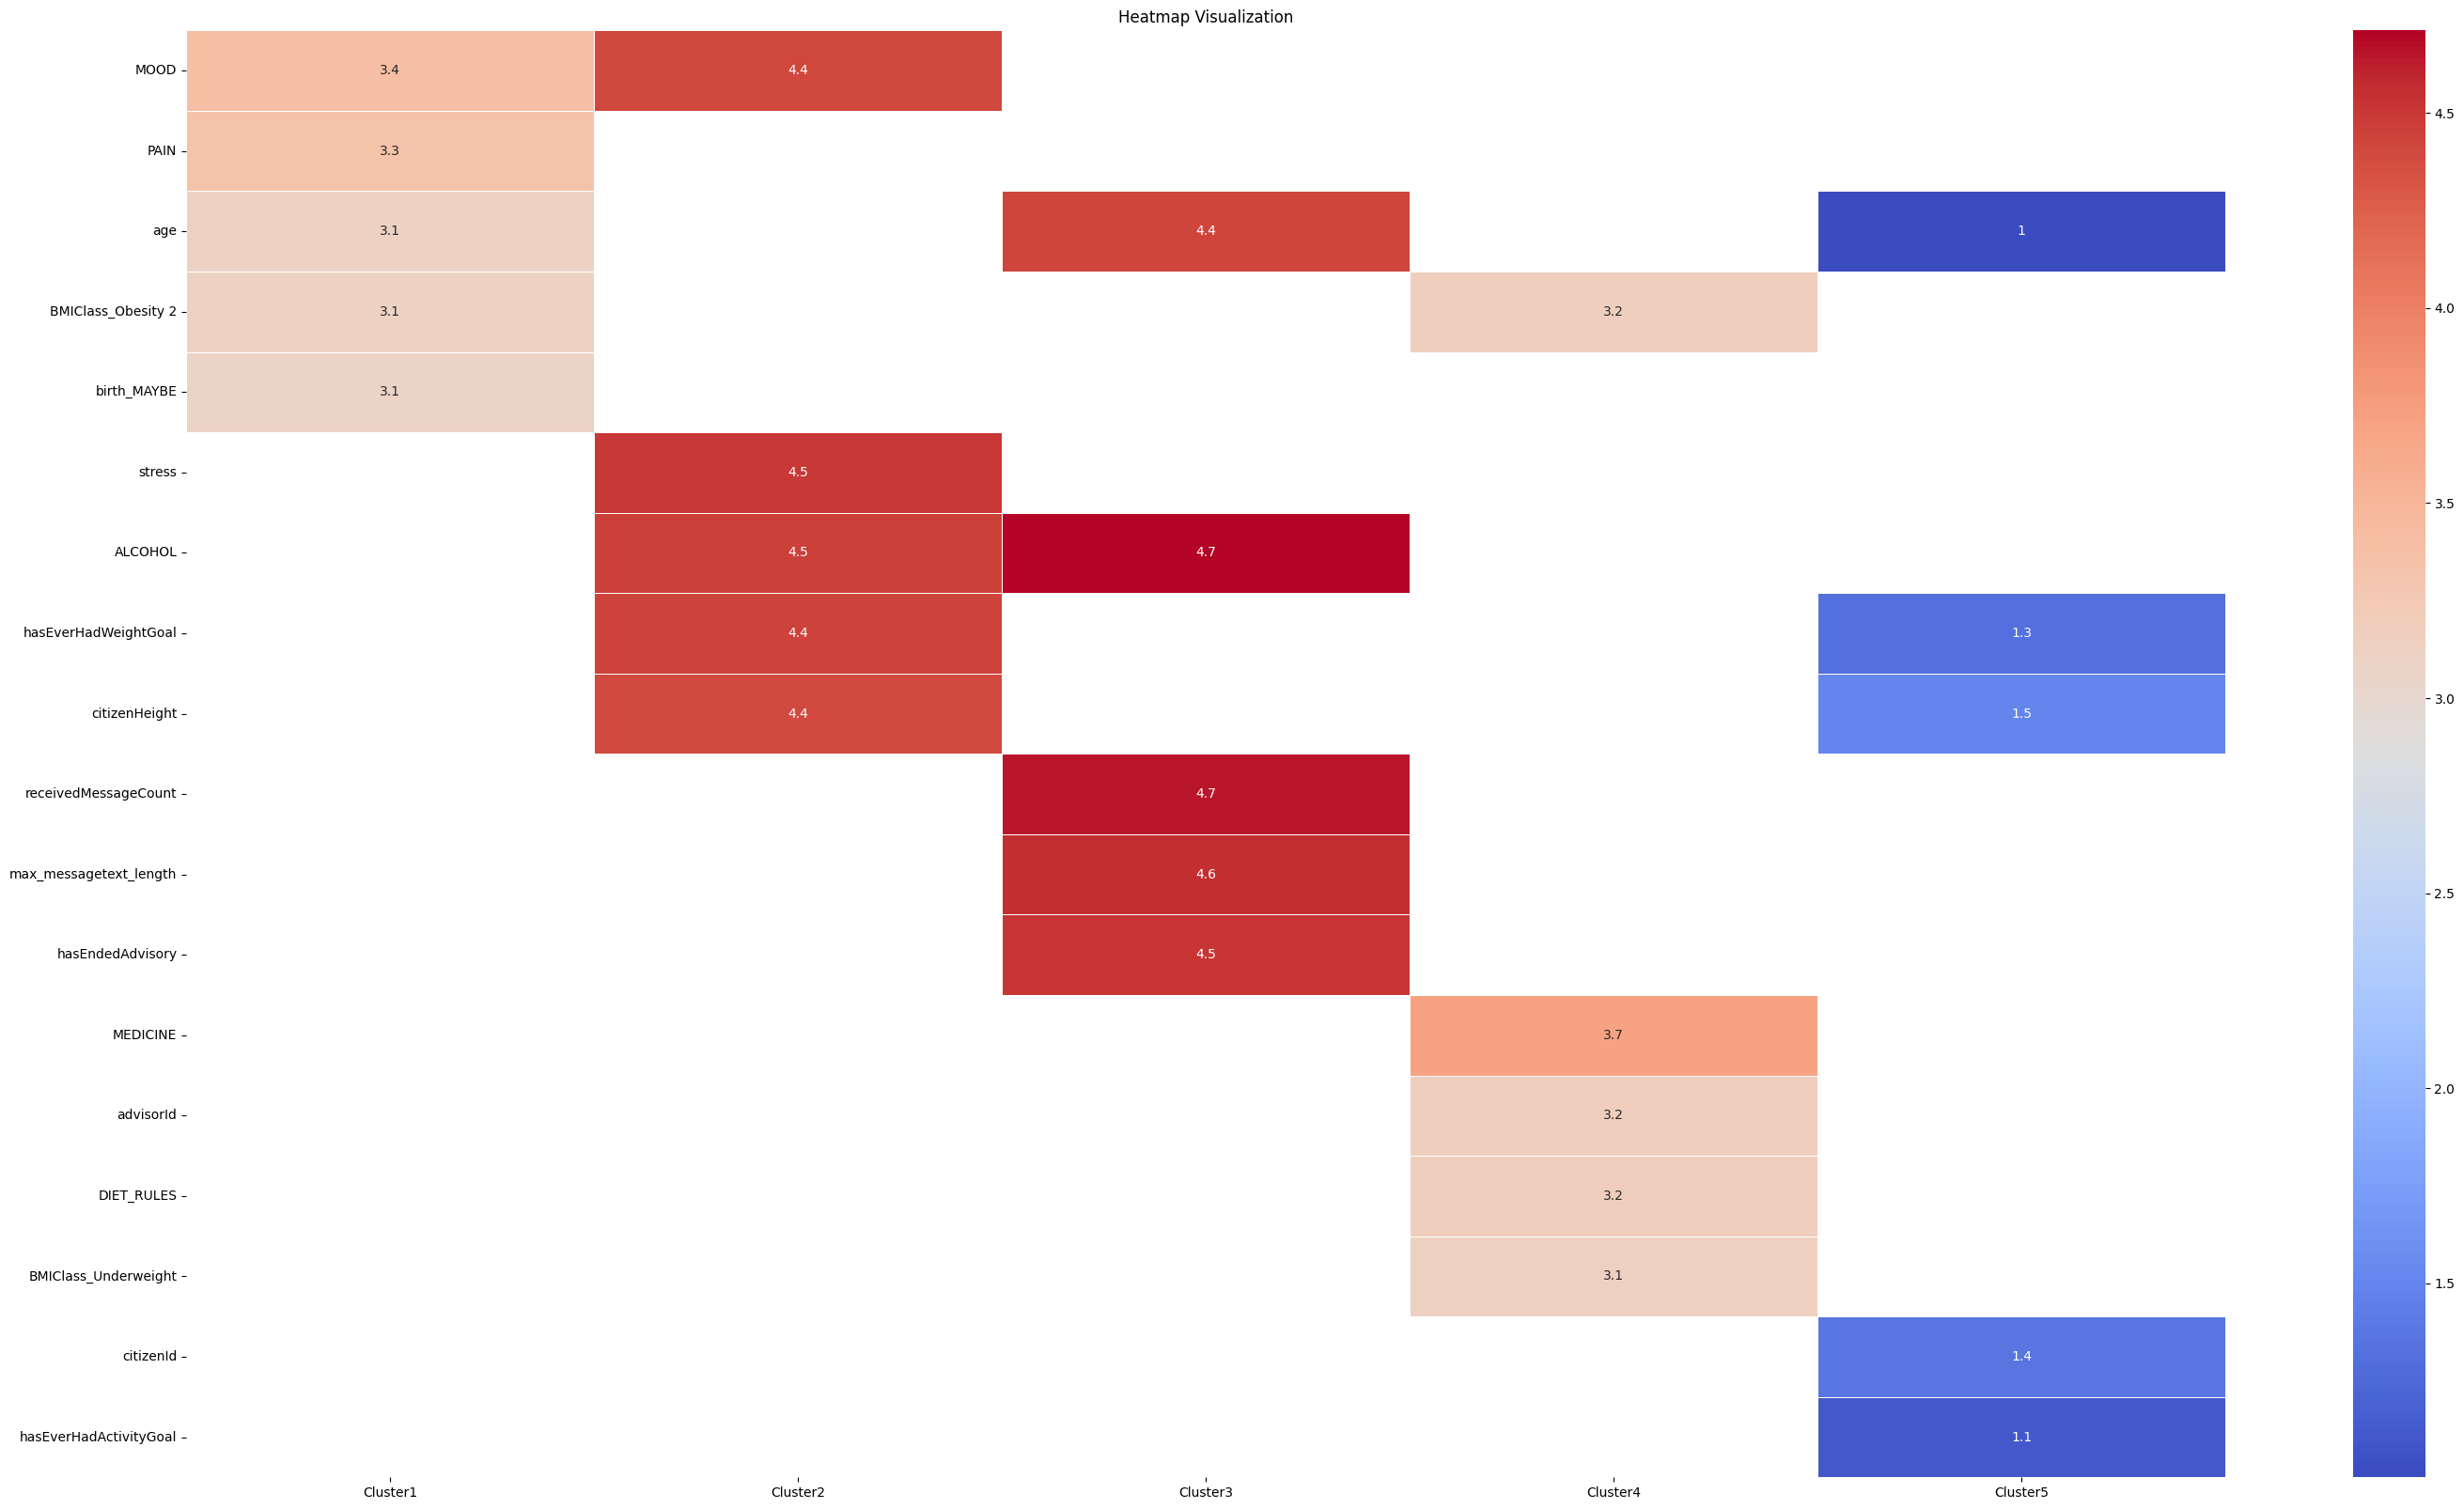

In [18]:
# Plot the heatmap
plt.figure(figsize=(35, 20))
sns.heatmap(top_10_df_transposed.T, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Visualization')
plt.show()

<ipython-input-25-a25763c12f1f>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=tick_font_size)


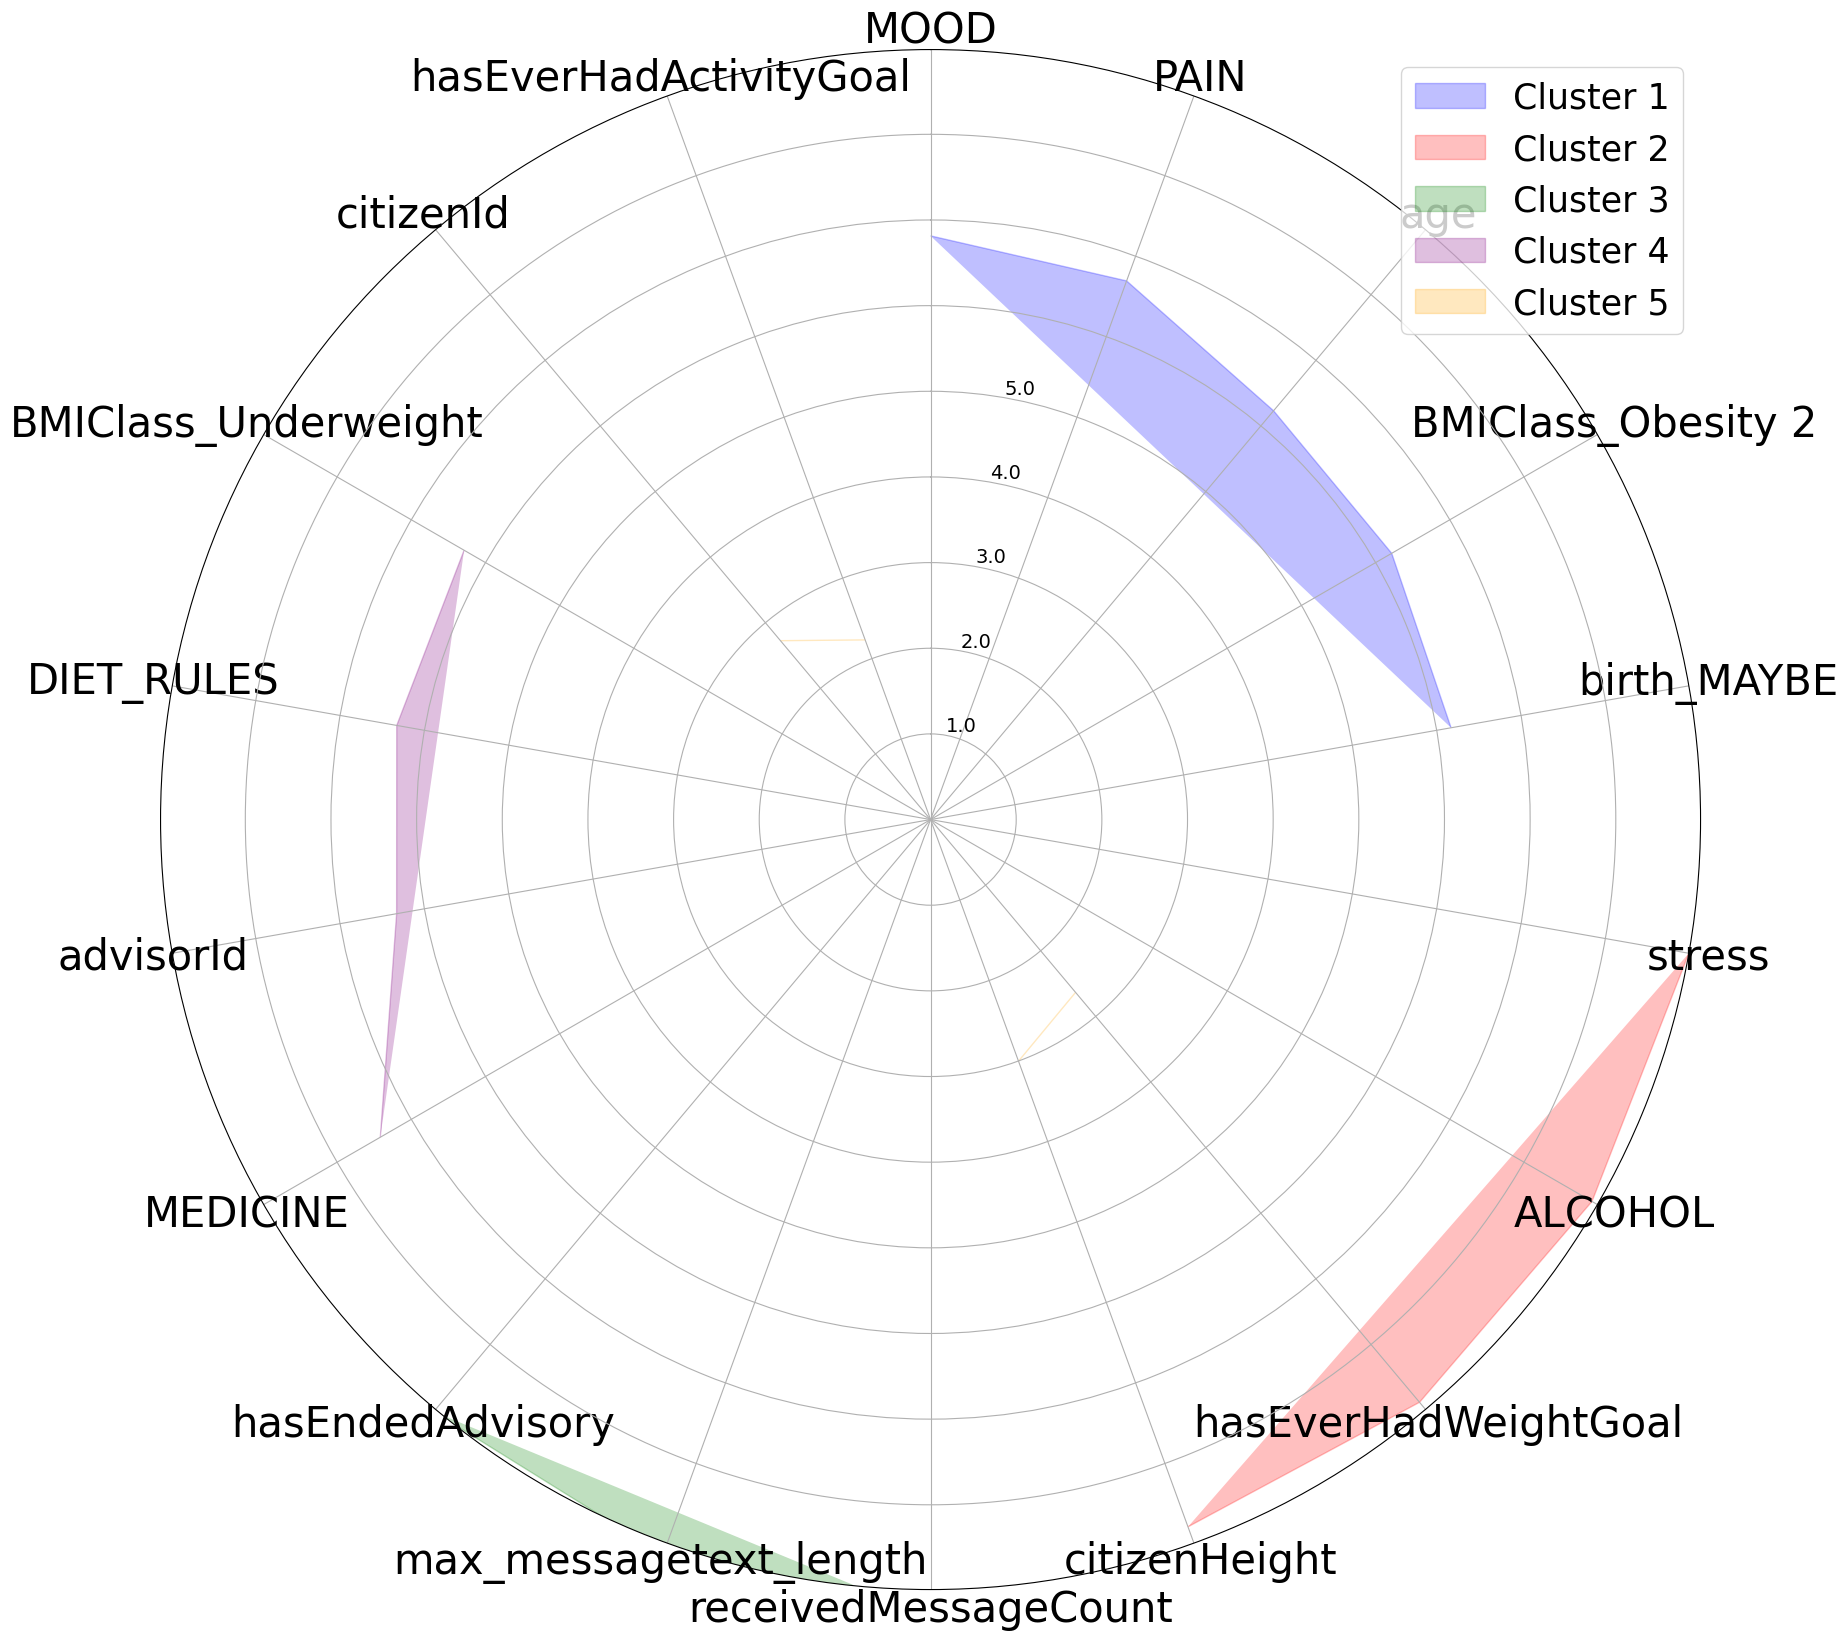

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# # Data
# labels = ['A', 'B', 'C']
# values = [
#     [1, 2, 3],
#     [5, 6, 2],
#     [4, 4, 4],
#     [2, 3, 5],
#     [3, 2, 1]
# ]

# Extract labels and values from DataFrame
labels = top_10_df_transposed.columns.tolist()
values = top_10_df_transposed.values.tolist()

# Set up the radar chart
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(polar=True))

colors = ['blue', 'red', 'green', 'purple', 'orange']

for i, val in enumerate(values):
    val += val[:1]
    ax.fill(angles, val, color=colors[i], alpha=0.25)

# Improve the appearance and add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)

# Set the font size here
label_font_size = 30  # You can adjust this size to your preference
tick_font_size = 14  # And also adjust this size accordingly

# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(labels)
# ax.set_ylim(0, max([max(v) for v in values]))

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=label_font_size)
ax.set_yticklabels(ax.get_yticks(), fontsize=tick_font_size)

# # Add legend
# ax.legend([f'Cluster {i+1}' for i in range(len(values))], loc='upper right')

# plt.show()

ax.set_ylim(0, max([max(v) for v in values]))

# Add legend with a larger font
legend_font_size = 25  # Adjust legend font size if necessary
ax.legend([f'Cluster {i+1}' for i in range(len(values))], loc='upper right', fontsize=legend_font_size)

plt.show()
